In [1]:
!pip install scikit-learn timm


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 97.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 5.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 63.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5

********

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import re
import gc
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import timm
import json

# --- CONFIGURATION AMÉLIORÉE ---
class Config:
    DRIVE_BASE_PATH = "/kaggle/working/"
    DUKE_DATA_PATH = "/kaggle/input/dukemtmcreid"
    MARKET_MODEL_PATH = "/kaggle/input/market/Market1501_clipreid_12x12sie_ViT-B-16_60.pth"
    BEST_MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "best_model_camera_refined.pth")
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    IMAGE_SIZE = (256, 128)

    ADAPTATION_EPOCHS = 50
    ADAPTATION_LR = 3.5e-5

    P = 16  # Identités par batch
    K = 4   # Instances par identité
    BATCH_SIZE = P * K

    EVAL_BATCH_SIZE = 128
    DBSCAN_MIN_SAMPLES = 4
    K_DISTANCE_PERCENTILE = 30
    MERGE_THRESHOLD = 0.9
    
    # PARAMÈTRES PROGRESSIVE PSEUDO-LABELING
    CONFIDENCE_THRESHOLD_START = 0.8
    CONFIDENCE_THRESHOLD_END = 0.6
    MIN_CLUSTER_SIZE = 4
    
    # PARAMÈTRES DE RÉGULARISATION
    MIXUP_ALPHA = 0.2
    MIXUP_PROB = 0.3
    TEMPERATURE_START = 0.1
    TEMPERATURE_END = 0.05
    HARD_MINING_RATIO = 0.5
    
    TRIPLET_MARGIN = 0.3
    EARLY_STOPPING_PATIENCE = 8
    
    # ---> NOUVEAUX PARAMÈTRES POUR LE RAFFINEMENT PAR CAMÉRA <---
    CAMERA_REFINEMENT_K = 10
    CAMERA_REFINEMENT_WEIGHT = 2.0


CONFIG = Config()
os.makedirs(CONFIG.DRIVE_BASE_PATH, exist_ok=True)
print(f"Configuration chargée avec Raffinage par Caméra. Appareil: {CONFIG.DEVICE}")

# --- MODÈLE ---
class ReidModel(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224_in21k'):
        super(ReidModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, img_size=CONFIG.IMAGE_SIZE)
        self.feature_dim = self.backbone.embed_dim
        self.bottleneck = nn.BatchNorm1d(self.feature_dim)
        self.bottleneck.bias.requires_grad_(False)
        nn.init.constant_(self.bottleneck.weight, 1.0)

    def forward(self, x):
        features = self.backbone(x)
        bn_features = self.bottleneck(features)
        return F.normalize(bn_features)

# --- DATASETS ---
class TestReIDDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self): 
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), img_path

class AdaptationDataset(Dataset):
    def __init__(self, image_paths, pseudo_labels, transform):
        self.image_paths = image_paths
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.pseudo_labels[index]
        img = self.transform(Image.open(img_path).convert('RGB'))
        return img, torch.tensor(label, dtype=torch.long)

# --- ÉCHANTILLONNEUR PAR IDENTITÉ ---
class RandomIdentitySampler(Sampler):
    def __init__(self, data_source, batch_size, num_instances):
        super().__init__(data_source)
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_instances = num_instances
        self.num_pids_per_batch = self.batch_size // self.num_instances
        
        self.index_dic = defaultdict(list)
        for index, pid in enumerate(self.data_source.pseudo_labels):
            if pid == -1: continue
            self.index_dic[int(pid)].append(index)
        
        self.pids = list(self.index_dic.keys())
        self.num_identities = len(self.pids)
        self.length = 0
        
        if self.num_identities >= self.num_pids_per_batch:
            self.length = (self.num_identities // self.num_pids_per_batch) * self.batch_size

    def __iter__(self):
        batch_idxs_dict = defaultdict(list)
        for pid in self.pids:
            idxs = np.random.choice(self.index_dic[pid], size=self.num_instances, replace=len(self.index_dic[pid]) < self.num_instances)
            batch_idxs_dict[pid].extend(idxs)
        
        avai_pids = self.pids.copy()
        final_idxs = []
        
        while len(avai_pids) >= self.num_pids_per_batch:
            selected_pids = np.random.choice(avai_pids, self.num_pids_per_batch, replace=False)
            for pid in selected_pids:
                final_idxs.extend(batch_idxs_dict[pid])
                avai_pids.remove(pid)
        return iter(final_idxs)

    def __len__(self): 
        return self.length

# --- FONCTION DE MIXUP CONTRASTIF ---
def mixup_contrastive(features, labels, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = features.size(0)
    unique_labels = torch.unique(labels)
    if len(unique_labels) < 2: return features, labels, None
    mixed_features, mixed_labels, mixup_info = [], [], []
    for i in range(batch_size):
        current_label = labels[i]
        different_labels = unique_labels[unique_labels != current_label]
        if len(different_labels) == 0: continue
        target_label = different_labels[torch.randint(len(different_labels), (1,))]
        target_indices = (labels == target_label).nonzero().squeeze()
        if target_indices.numel() == 0: continue
        target_idx = target_indices[torch.randint(len(target_indices), (1,))] if target_indices.numel() > 1 else target_indices
        mixed_feature = lam * features[i] + (1 - lam) * features[target_idx]
        mixed_features.append(mixed_feature)
        mixed_labels.append(current_label)
        mixup_info.append({'lam': lam, 'target_label': target_label.item()})
    if len(mixed_features) > 0: return torch.stack(mixed_features), torch.tensor(mixed_labels).to(features.device), mixup_info
    else: return features, labels, None

# --- LOSS AVEC TEMPÉRATURE ADAPTATIVE ET HARD MINING ---
def advanced_triplet_loss_with_temperature(features, labels, margin, temperature, hard_mining_ratio=0.5):
    dist_mat = torch.cdist(features, features, p=2) / temperature
    N = features.size(0)
    is_pos = labels.expand(N, N).eq(labels.expand(N, N).t())
    is_neg = ~is_pos
    is_pos.fill_diagonal_(False)
    pos_dists = dist_mat * is_pos.float(); pos_dists[~is_pos] = float('-inf')
    dist_ap = pos_dists.max(dim=1)[0]
    neg_dists = dist_mat * is_neg.float(); neg_dists[~is_neg] = float('inf')
    dist_an = neg_dists.min(dim=1)[0]
    individual_losses = F.relu(dist_ap - dist_an + margin)
    n_hard = int(N * hard_mining_ratio)
    if n_hard > 0:
        hard_indices = torch.topk(individual_losses, n_hard)[1]
        return individual_losses[hard_indices].mean()
    return individual_losses.mean()

# --- FONCTION DE PROGRESSIVE PSEUDO-LABELING ---
def progressive_pseudo_labeling_with_confidence(features, epoch, max_epochs):
    print(f"Progressive Pseudo-Labeling - Epoch {epoch+1}/{max_epochs}")
    progress = epoch / max_epochs
    confidence_threshold = CONFIG.CONFIDENCE_THRESHOLD_START - progress * (CONFIG.CONFIDENCE_THRESHOLD_START - CONFIG.CONFIDENCE_THRESHOLD_END)
    print(f"Seuil de confiance actuel: {confidence_threshold:.3f}")
    nn_calculator = NearestNeighbors(n_neighbors=CONFIG.DBSCAN_MIN_SAMPLES + 1, metric='cosine', n_jobs=-1)
    nn_calculator.fit(features)
    distances, _ = nn_calculator.kneighbors(features)
    eps = np.percentile(distances[:, -1], CONFIG.K_DISTANCE_PERCENTILE)
    initial_labels = DBSCAN(eps=eps, min_samples=CONFIG.DBSCAN_MIN_SAMPLES, metric='cosine', n_jobs=-1).fit_predict(features.numpy())
    confidences = np.zeros(len(features))
    cluster_ids = np.unique(initial_labels[initial_labels != -1])
    for cluster_id in cluster_ids:
        cluster_mask = (initial_labels == cluster_id)
        if np.sum(cluster_mask) < CONFIG.MIN_CLUSTER_SIZE: continue
        cluster_features = features[cluster_mask]
        cluster_centroid = cluster_features.mean(dim=0, keepdim=True)
        similarities = F.cosine_similarity(cluster_features, cluster_centroid)
        confidences[cluster_mask] = similarities.cpu().numpy()
    confident_mask = confidences >= confidence_threshold
    pseudo_labels = np.full(len(features), -1, dtype=int)
    new_label = 0
    for cluster_id in cluster_ids:
        cluster_mask = (initial_labels == cluster_id) & confident_mask
        if np.sum(cluster_mask) >= CONFIG.MIN_CLUSTER_SIZE:
            pseudo_labels[cluster_mask] = new_label
            new_label += 1
    if new_label > 1:
        pseudo_labels = merge_clusters_confident(features, pseudo_labels, confidences, CONFIG.MERGE_THRESHOLD)
    n_labeled = np.sum(pseudo_labels != -1)
    n_clusters = len(np.unique(pseudo_labels[pseudo_labels != -1]))
    print(f"Échantillons étiquetés après filtrage: {n_labeled}/{len(features)} ({n_labeled/len(features)*100:.1f}%)")
    print(f"Nombre de clusters (pré-raffinement): {n_clusters}")
    return pseudo_labels, confidences

def merge_clusters_confident(features, pseudo_labels, confidences, threshold):
    cluster_ids = np.unique(pseudo_labels[pseudo_labels != -1])
    if len(cluster_ids) <= 1: return pseudo_labels
    centroids = []
    for cid in cluster_ids:
        mask = (pseudo_labels == cid)
        w_centroid = (features[mask] * torch.tensor(confidences[mask]).unsqueeze(1).to(features.device)).sum(dim=0) / torch.tensor(confidences[mask]).sum()
        centroids.append(w_centroid)
    centroids = torch.stack(centroids)
    sim_matrix = torch.mm(F.normalize(centroids), F.normalize(centroids).t())
    parent = {cid: cid for cid in cluster_ids}
    def find_root(cid):
        root = cid
        while root != parent[root]: root = parent[root]
        while cid != root: next_cid, parent[cid] = parent[cid], root; cid = next_cid
        return root
    def union(cid1, cid2):
        root1, root2 = find_root(cid1), find_root(cid2)
        if root1 != root2: parent[max(root1, root2)] = min(root1, root2)
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            if sim_matrix[i, j] > threshold: union(cluster_ids[i], cluster_ids[j])
    new_labels = np.copy(pseudo_labels)
    for i, label in enumerate(pseudo_labels):
        if label != -1: new_labels[i] = find_root(label)
    n_before = len(cluster_ids)
    n_after = len(np.unique(new_labels[new_labels != -1]))
    if n_before > n_after: print(f"Fusion: {n_before} clusters -> {n_after} clusters")
    return new_labels

# ================================================================================= #
# ===> NOTRE SOLUTION : RAFFINAGE DES LABELS PAR A-PRIORI DE CAMÉRA <===
# ================================================================================= #
def refine_labels_with_camera_priors(features, pseudo_labels, camids, k, cross_cam_weight):
    """
    Raffine les pseudo-labels en se basant sur un vote des k-NN pondéré par les caméras.
    Un vote d'un voisin provenant d'une caméra différente a plus de poids.
    """
    print(f"Raffinage des labels avec les a-priori caméra (k={k}, weight={cross_cam_weight})...")
    
    labeled_mask = pseudo_labels != -1
    labeled_indices = np.where(labeled_mask)[0]
    
    if len(labeled_indices) < k + 1:
        print("Pas assez d'échantillons labellisés pour le raffinement. Passage.")
        return pseudo_labels

    # Travailler uniquement sur les données qui ont reçu un label
    labeled_features = features[labeled_mask]
    labeled_pseudos = pseudo_labels[labeled_mask]
    labeled_camids = camids[labeled_mask]
    
    nn = NearestNeighbors(n_neighbors=k + 1, metric='cosine', n_jobs=-1)
    nn.fit(labeled_features)
    distances, indices = nn.kneighbors(labeled_features)
    
    refined_labels = pseudo_labels.copy()
    num_changed = 0

    for i in range(len(labeled_indices)):
        original_idx_in_full_array = labeled_indices[i]
        current_label = labeled_pseudos[i]
        current_camid = labeled_camids[i]
        
        # Les indices des voisins sont relatifs au sous-ensemble "labeled"
        neighbor_relative_indices = indices[i, 1:]
        
        votes = defaultdict(float)
        for neighbor_relative_idx in neighbor_relative_indices:
            neighbor_label = labeled_pseudos[neighbor_relative_idx]
            neighbor_camid = labeled_camids[neighbor_relative_idx]
            
            # La logique clé : donner plus de poids aux votes inter-caméras
            weight = cross_cam_weight if neighbor_camid != current_camid else 1.0
            votes[neighbor_label] += weight
            
        if not votes: continue
            
        best_label = max(votes, key=votes.get)
        
        if best_label != current_label:
            refined_labels[original_idx_in_full_array] = best_label
            num_changed += 1
            
    if num_changed > 0:
        print(f"Raffinage terminé. {num_changed} labels ({num_changed/len(labeled_indices):.2%}) ont été modifiés/corrigés.")
    else:
        print("Raffinage terminé. Aucun label n'a été modifié.")
        
    return refined_labels

# --- FONCTIONS UTILITAIRES ET D'ÉVALUATION ---
def _parse_info_from_paths(paths):
    return (np.array([int(re.search(r'([-\d]+)_c', os.path.basename(p)).group(1)) for p in paths]),
            np.array([int(re.search(r'_c(\d+)', os.path.basename(p)).group(1)) for p in paths]))

def extract_features(model, loader):
    model.eval()
    features_list, path_list = [], []
    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc="Extraction des features"):
            features_list.append(model(imgs.to(CONFIG.DEVICE)).cpu())
            path_list.extend(paths)
    return torch.cat(features_list), path_list

def evaluate_from_distmat(distmat, q_pids, g_pids, q_camids, g_camids):
    indices = np.argsort(distmat, axis=1)
    cmc, all_ap, num_valid_q = np.zeros(len(g_pids)), [], 0
    for i in range(len(q_pids)):
        q_pid, q_camid = q_pids[i], q_camids[i]
        matches = (g_pids[indices[i]] == q_pid).astype(np.int32)
        remove = (g_pids[indices[i]] == q_pid) & (g_camids[indices[i]] == q_camid)
        orig_cmc = matches[~remove]
        if not np.any(orig_cmc): continue
        num_valid_q += 1
        cmc[np.where(orig_cmc == 1)[0][0]:] += 1
        pos_idx = np.where(orig_cmc == 1)[0]
        ap = sum((k + 1) / (pos + 1) for k, pos in enumerate(pos_idx)) / len(pos_idx)
        all_ap.append(ap)
    if num_valid_q == 0: return 0.0, np.zeros_like(cmc)
    return np.mean(all_ap), cmc / num_valid_q

def load_pretrained_weights(model, path):
    try:
        sd = torch.load(path, map_location=CONFIG.DEVICE)
        sd = sd.get('model', sd.get('state_dict', sd))
        new_sd = {k.replace('image_encoder.', 'backbone.'): v for k, v in sd.items() if k.startswith('image_encoder.')}
        model.load_state_dict(new_sd, strict=False)
        print(f"Poids pré-entraînés chargés depuis: {path}")
    except Exception as e: print(f"Erreur de chargement: {e}"); raise e

def comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids, epoch=None):
    model.eval()
    desc = f"Évaluation Epoch {epoch+1}" if epoch is not None else "Évaluation finale"
    print(desc + "...")
    q_feat, _ = extract_features(model, query_loader)
    g_feat, _ = extract_features(model, gallery_loader)
    distmat_cosine = 1 - torch.mm(q_feat, g_feat.t()).numpy()
    mAP_cosine, cmc_cosine = evaluate_from_distmat(distmat_cosine, q_pids, g_pids, q_camids, g_camids)
    print(f"  => Cosine - mAP: {mAP_cosine:.2%}, Rank-1: {cmc_cosine[0]:.2%}")
    return {'mAP_cosine': mAP_cosine, 'rank1_cosine': cmc_cosine[0], 'rank5_cosine': cmc_cosine[4], 'rank10_cosine': cmc_cosine[9]}


# --- SCRIPT PRINCIPAL ---
if __name__ == "__main__":
    # Transformations
    transform_test = transforms.Compose([transforms.Resize(CONFIG.IMAGE_SIZE), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])
    transform_train = transforms.Compose([
        transforms.Resize(CONFIG.IMAGE_SIZE, interpolation=3), transforms.RandomHorizontalFlip(), 
        transforms.Pad(10), transforms.RandomCrop(CONFIG.IMAGE_SIZE), 
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1), transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3), transforms.RandomErasing(p=0.5)
    ])

    # Datasets et DataLoaders
    query_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'query'), transform_test)
    gallery_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_test'), transform_test)
    train_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_train'), transform_test)
    
    # MODIFICATION : On extrait les IDs de caméra pour tous les ensembles de données
    q_pids, q_camids = _parse_info_from_paths(query_dataset.img_paths)
    g_pids, g_camids = _parse_info_from_paths(gallery_dataset.img_paths)
    train_pids, train_camids = _parse_info_from_paths(train_dataset.img_paths)

    query_loader = DataLoader(query_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    gallery_loader = DataLoader(gallery_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    train_feature_loader = DataLoader(train_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)

    # Évaluation du modèle de base
    print("\n" + "="*50 + "\n### ÉVALUATION DU MODÈLE DE BASE (SANS ADAPTATION) ###\n" + "="*50)
    baseline_model = ReidModel().to(CONFIG.DEVICE)
    load_pretrained_weights(baseline_model, CONFIG.MARKET_MODEL_PATH)
    baseline_results = comprehensive_evaluation(baseline_model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids)
    del baseline_model; gc.collect(); torch.cuda.empty_cache()

    # Adaptation
    print("\n" + "="*50 + "\n### DÉBUT DE L'ADAPTATION DE DOMAINE AVEC RAFFINEMENT ###\n" + "="*50)
    model = ReidModel().to(CONFIG.DEVICE)
    load_pretrained_weights(model, CONFIG.MARKET_MODEL_PATH)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.ADAPTATION_LR, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    patience, best_mAP, avg_loss = 0, 0, 0.0
    training_history = []

    for epoch in range(CONFIG.ADAPTATION_EPOCHS):
        print(f"\n--- ADAPTATION EPOCH {epoch+1}/{CONFIG.ADAPTATION_EPOCHS} ---")
        
        # --- ÉTAPE 1: GÉNÉRATION DES PSEUDO-LABELS BRUTS ---
        model.eval()
        all_features, _ = extract_features(model, train_feature_loader)
        pseudo_labels, confidences = progressive_pseudo_labeling_with_confidence(all_features, epoch, CONFIG.ADAPTATION_EPOCHS)
        
        # --- ÉTAPE 2: RAFFINEMENT DES LABELS EN UTILISANT LES CAMÉRAS ---
        refined_pseudo_labels = refine_labels_with_camera_priors(
            all_features.cpu().numpy(), pseudo_labels, train_camids,
            k=CONFIG.CAMERA_REFINEMENT_K,
            cross_cam_weight=CONFIG.CAMERA_REFINEMENT_WEIGHT
        )
        
        # --- ÉTAPE 3: ENTRAÎNEMENT SUR LES LABELS RAFFINÉS ---
        adapt_dataset_instance = AdaptationDataset(train_dataset.img_paths, refined_pseudo_labels, transform_train)
        sampler = RandomIdentitySampler(adapt_dataset_instance, CONFIG.BATCH_SIZE, CONFIG.K)
        
        if len(sampler) > 0:
            adapt_loader = DataLoader(adapt_dataset_instance, batch_size=CONFIG.BATCH_SIZE, sampler=sampler, num_workers=2, drop_last=True)
            model.train()
            total_loss, num_batches = 0.0, 0
            
            progress = epoch / (CONFIG.ADAPTATION_EPOCHS - 1)
            current_temperature = CONFIG.TEMPERATURE_START - progress * (CONFIG.TEMPERATURE_START - CONFIG.TEMPERATURE_END)
            
            for imgs, labels in tqdm(adapt_loader, desc=f"Training Epoch {epoch+1}"):
                optimizer.zero_grad()
                imgs, labels = imgs.to(CONFIG.DEVICE), labels.to(CONFIG.DEVICE)
                features = model(imgs)
                
                if np.random.random() < CONFIG.MIXUP_PROB:
                    mixed_features, mixed_labels, info = mixup_contrastive(features, labels, CONFIG.MIXUP_ALPHA)
                    if info:
                        loss = 0.7 * advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO) + \
                               0.3 * advanced_triplet_loss_with_temperature(mixed_features, mixed_labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                    else:
                        loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                else:
                    loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                
                if loss.item() > 0:
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                    num_batches += 1
            
            avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
            print(f"Loss moyenne: {avg_loss:.4f}")
            lr_scheduler.step()
        else:
            print("Aucun batch d'entraînement généré, passage de l'époque.")

        # Validation
        validation_results = comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids, epoch)
        current_mAP = validation_results['mAP_cosine']
        history_entry = {'epoch': epoch + 1, 'loss': avg_loss, 'n_labeled': np.sum(refined_pseudo_labels != -1), **validation_results}
        training_history.append(history_entry)
        
        # Sauvegarde et Early stopping
        if current_mAP > best_mAP:
            best_mAP = current_mAP
            patience = 0
            print(f"🏆 Nouveau meilleur mAP: {best_mAP:.2%}! Sauvegarde du modèle...")
            torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'best_mAP': best_mAP}, CONFIG.BEST_MODEL_SAVE_PATH)
        else:
            patience += 1
            print(f"Patience: {patience}/{CONFIG.EARLY_STOPPING_PATIENCE}")
        
        if patience >= CONFIG.EARLY_STOPPING_PATIENCE:
            print(f"🛑 Early stopping. Meilleur mAP obtenu: {best_mAP:.2%}")
            break
    
    print("\n" + "="*50 + "\n### ÉVALUATION FINALE DU MEILLEUR MODÈLE ###\n" + "="*50)
    
    if os.path.exists(CONFIG.BEST_MODEL_SAVE_PATH):
        print("Chargement du meilleur modèle sauvegardé pour l'évaluation finale...")
        checkpoint = torch.load(CONFIG.BEST_MODEL_SAVE_PATH, map_location=CONFIG.DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Modèle de l'époque {checkpoint['epoch']} (mAP: {checkpoint['best_mAP']:.2%}) chargé.")
        
        final_results = comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids)
        
        print("\n" + "="*60 + "\n### RÉSULTATS FINAUX ###\n" + "="*60)
        print(f"BASELINE (SANS ADAPTATION):")
        print(f"  - mAP: {baseline_results['mAP_cosine']:.2%}, Rank-1: {baseline_results['rank1_cosine']:.2%}")
        
        print(f"\nMODÈLE ADAPTÉ (AVEC RAFFINEMENT PAR CAMÉRA):")
        print(f"  - mAP: {final_results['mAP_cosine']:.2%} (Amélioration: {final_results['mAP_cosine']/baseline_results['mAP_cosine']-1:+.1%})")
        print(f"  - Rank-1: {final_results['rank1_cosine']:.2%} (Amélioration: {final_results['rank1_cosine']/baseline_results['rank1_cosine']-1:+.1%})")
    else:
        print("Aucun modèle n'a été sauvegardé. Impossible de faire l'évaluation finale.")

    print("\n🎉 ADAPTATION TERMINÉE! 🎉")

Configuration chargée avec Raffinage par Caméra. Appareil: cuda

### ÉVALUATION DU MODÈLE DE BASE (SANS ADAPTATION) ###


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Poids pré-entraînés chargés depuis: /kaggle/input/market/Market1501_clipreid_12x12sie_ViT-B-16_60.pth
Évaluation finale...


Extraction des features: 100%|██████████| 138/138 [02:15<00:00,  1.02it/s]


  => Cosine - mAP: 3.26%, Rank-1: 7.85%

### DÉBUT DE L'ADAPTATION DE DOMAINE AVEC RAFFINEMENT ###
Poids pré-entraînés chargés depuis: /kaggle/input/market/Market1501_clipreid_12x12sie_ViT-B-16_60.pth

--- ADAPTATION EPOCH 1/50 ---


Extraction des features: 100%|██████████| 130/130 [02:04<00:00,  1.04it/s]


Progressive Pseudo-Labeling - Epoch 1/50
Seuil de confiance actuel: 0.800
Fusion: 201 clusters -> 198 clusters
Échantillons étiquetés après filtrage: 3421/16522 (20.7%)
Nombre de clusters (pré-raffinement): 198
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 494 labels (14.44%) ont été modifiés/corrigés.


Training Epoch 1: 100%|██████████| 8/8 [00:12<00:00,  1.59s/it]


Loss moyenne: 0.4760
Évaluation Epoch 1...


Extraction des features: 100%|██████████| 138/138 [02:12<00:00,  1.04it/s]


  => Cosine - mAP: 6.70%, Rank-1: 14.23%
🏆 Nouveau meilleur mAP: 6.70%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 2/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 2/50
Seuil de confiance actuel: 0.796


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Échantillons étiquetés après filtrage: 2312/16522 (14.0%)
Nombre de clusters (pré-raffinement): 370
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...
Raffinage terminé. 426 labels (18.43%) ont été modifiés/corrigés.


Training Epoch 2: 100%|██████████| 21/21 [00:30<00:00,  1.44s/it]


Loss moyenne: 0.4532
Évaluation Epoch 2...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 10.13%, Rank-1: 19.39%
🏆 Nouveau meilleur mAP: 10.13%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 3/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 3/50
Seuil de confiance actuel: 0.792


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Échantillons étiquetés après filtrage: 1980/16522 (12.0%)
Nombre de clusters (pré-raffinement): 355
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...
Raffinage terminé. 583 labels (29.44%) ont été modifiés/corrigés.


Training Epoch 3: 100%|██████████| 20/20 [00:28<00:00,  1.43s/it]


Loss moyenne: 0.6670
Évaluation Epoch 3...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 12.06%, Rank-1: 23.25%
🏆 Nouveau meilleur mAP: 12.06%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 4/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 4/50
Seuil de confiance actuel: 0.788
Échantillons étiquetés après filtrage: 3025/16522 (18.3%)
Nombre de clusters (pré-raffinement): 477
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 687 labels (22.71%) ont été modifiés/corrigés.


Training Epoch 4: 100%|██████████| 27/27 [00:39<00:00,  1.45s/it]


Loss moyenne: 0.4765
Évaluation Epoch 4...


Extraction des features: 100%|██████████| 138/138 [02:10<00:00,  1.05it/s]


  => Cosine - mAP: 22.76%, Rank-1: 37.48%
🏆 Nouveau meilleur mAP: 22.76%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 5/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 5/50
Seuil de confiance actuel: 0.784
Échantillons étiquetés après filtrage: 5040/16522 (30.5%)
Nombre de clusters (pré-raffinement): 721
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1114 labels (22.10%) ont été modifiés/corrigés.


Training Epoch 5: 100%|██████████| 41/41 [00:57<00:00,  1.41s/it]


Loss moyenne: 0.2583
Évaluation Epoch 5...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 26.49%, Rank-1: 43.04%
🏆 Nouveau meilleur mAP: 26.49%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 6/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 6/50
Seuil de confiance actuel: 0.780
Échantillons étiquetés après filtrage: 5841/16522 (35.4%)
Nombre de clusters (pré-raffinement): 755
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1198 labels (20.51%) ont été modifiés/corrigés.


Training Epoch 6: 100%|██████████| 42/42 [00:59<00:00,  1.43s/it]


Loss moyenne: 0.2433
Évaluation Epoch 6...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 25.04%, Rank-1: 41.74%
Patience: 1/8

--- ADAPTATION EPOCH 7/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 7/50
Seuil de confiance actuel: 0.776
Échantillons étiquetés après filtrage: 5779/16522 (35.0%)
Nombre de clusters (pré-raffinement): 753
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1137 labels (19.67%) ont été modifiés/corrigés.


Training Epoch 7: 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


Loss moyenne: 0.2683
Évaluation Epoch 7...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 30.18%, Rank-1: 50.49%
🏆 Nouveau meilleur mAP: 30.18%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 8/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 8/50
Seuil de confiance actuel: 0.772
Échantillons étiquetés après filtrage: 6569/16522 (39.8%)
Nombre de clusters (pré-raffinement): 813
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1367 labels (20.81%) ont été modifiés/corrigés.


Training Epoch 8: 100%|██████████| 44/44 [01:02<00:00,  1.43s/it]


Loss moyenne: 0.2691
Évaluation Epoch 8...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 33.07%, Rank-1: 52.15%
🏆 Nouveau meilleur mAP: 33.07%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 9/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 9/50
Seuil de confiance actuel: 0.768
Échantillons étiquetés après filtrage: 6611/16522 (40.0%)
Nombre de clusters (pré-raffinement): 789
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1420 labels (21.48%) ont été modifiés/corrigés.


Training Epoch 9: 100%|██████████| 43/43 [01:01<00:00,  1.43s/it]


Loss moyenne: 0.2057
Évaluation Epoch 9...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 35.76%, Rank-1: 55.66%
🏆 Nouveau meilleur mAP: 35.76%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 10/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 10/50
Seuil de confiance actuel: 0.764
Échantillons étiquetés après filtrage: 6863/16522 (41.5%)
Nombre de clusters (pré-raffinement): 787
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1423 labels (20.73%) ont été modifiés/corrigés.


Training Epoch 10: 100%|██████████| 42/42 [00:59<00:00,  1.41s/it]


Loss moyenne: 0.2255
Évaluation Epoch 10...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 34.97%, Rank-1: 54.58%
Patience: 1/8

--- ADAPTATION EPOCH 11/50 ---


Extraction des features: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 11/50
Seuil de confiance actuel: 0.760
Échantillons étiquetés après filtrage: 7032/16522 (42.6%)
Nombre de clusters (pré-raffinement): 780
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1431 labels (20.35%) ont été modifiés/corrigés.


Training Epoch 11: 100%|██████████| 42/42 [00:58<00:00,  1.39s/it]


Loss moyenne: 0.2224
Évaluation Epoch 11...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 37.06%, Rank-1: 57.36%
🏆 Nouveau meilleur mAP: 37.06%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 12/50 ---


Extraction des features: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 12/50
Seuil de confiance actuel: 0.756
Échantillons étiquetés après filtrage: 7302/16522 (44.2%)
Nombre de clusters (pré-raffinement): 791
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1464 labels (20.05%) ont été modifiés/corrigés.


Training Epoch 12: 100%|██████████| 42/42 [01:00<00:00,  1.43s/it]


Loss moyenne: 0.2488
Évaluation Epoch 12...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 35.83%, Rank-1: 56.55%
Patience: 1/8

--- ADAPTATION EPOCH 13/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 13/50
Seuil de confiance actuel: 0.752
Échantillons étiquetés après filtrage: 7036/16522 (42.6%)
Nombre de clusters (pré-raffinement): 771
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1337 labels (19.00%) ont été modifiés/corrigés.


Training Epoch 13: 100%|██████████| 42/42 [00:59<00:00,  1.42s/it]


Loss moyenne: 0.2274
Évaluation Epoch 13...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 37.65%, Rank-1: 58.66%
🏆 Nouveau meilleur mAP: 37.65%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 14/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 14/50
Seuil de confiance actuel: 0.748
Échantillons étiquetés après filtrage: 7161/16522 (43.3%)
Nombre de clusters (pré-raffinement): 756
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1438 labels (20.08%) ont été modifiés/corrigés.


Training Epoch 14: 100%|██████████| 40/40 [00:56<00:00,  1.42s/it]


Loss moyenne: 0.2719
Évaluation Epoch 14...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 39.45%, Rank-1: 60.23%
🏆 Nouveau meilleur mAP: 39.45%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 15/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 15/50
Seuil de confiance actuel: 0.744
Échantillons étiquetés après filtrage: 7418/16522 (44.9%)
Nombre de clusters (pré-raffinement): 762
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1471 labels (19.83%) ont été modifiés/corrigés.


Training Epoch 15: 100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


Loss moyenne: 0.1968
Évaluation Epoch 15...


Extraction des features: 100%|██████████| 138/138 [02:10<00:00,  1.05it/s]


  => Cosine - mAP: 39.97%, Rank-1: 59.74%
🏆 Nouveau meilleur mAP: 39.97%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 16/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 16/50
Seuil de confiance actuel: 0.740
Échantillons étiquetés après filtrage: 7508/16522 (45.4%)
Nombre de clusters (pré-raffinement): 743
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1423 labels (18.95%) ont été modifiés/corrigés.


Training Epoch 16: 100%|██████████| 40/40 [00:57<00:00,  1.43s/it]


Loss moyenne: 0.2049
Évaluation Epoch 16...


Extraction des features: 100%|██████████| 138/138 [02:10<00:00,  1.05it/s]


  => Cosine - mAP: 41.05%, Rank-1: 61.49%
🏆 Nouveau meilleur mAP: 41.05%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 17/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 17/50
Seuil de confiance actuel: 0.736
Échantillons étiquetés après filtrage: 7517/16522 (45.5%)
Nombre de clusters (pré-raffinement): 754
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1507 labels (20.05%) ont été modifiés/corrigés.


Training Epoch 17: 100%|██████████| 39/39 [00:54<00:00,  1.41s/it]


Loss moyenne: 0.2070
Évaluation Epoch 17...


Extraction des features: 100%|██████████| 138/138 [02:10<00:00,  1.05it/s]


  => Cosine - mAP: 41.44%, Rank-1: 61.94%
🏆 Nouveau meilleur mAP: 41.44%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 18/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 18/50
Seuil de confiance actuel: 0.732
Échantillons étiquetés après filtrage: 7591/16522 (45.9%)
Nombre de clusters (pré-raffinement): 763
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1591 labels (20.96%) ont été modifiés/corrigés.


Training Epoch 18: 100%|██████████| 39/39 [00:54<00:00,  1.40s/it]


Loss moyenne: 0.2304
Évaluation Epoch 18...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.16%, Rank-1: 62.39%
🏆 Nouveau meilleur mAP: 42.16%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 19/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 19/50
Seuil de confiance actuel: 0.728
Échantillons étiquetés après filtrage: 7619/16522 (46.1%)
Nombre de clusters (pré-raffinement): 767
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1607 labels (21.09%) ont été modifiés/corrigés.


Training Epoch 19: 100%|██████████| 39/39 [00:55<00:00,  1.44s/it]


Loss moyenne: 0.2209
Évaluation Epoch 19...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.72%, Rank-1: 63.02%
🏆 Nouveau meilleur mAP: 42.72%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 20/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 20/50
Seuil de confiance actuel: 0.724
Échantillons étiquetés après filtrage: 7696/16522 (46.6%)
Nombre de clusters (pré-raffinement): 782
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1649 labels (21.43%) ont été modifiés/corrigés.


Training Epoch 20: 100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


Loss moyenne: 0.2427
Évaluation Epoch 20...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.76%, Rank-1: 63.11%
🏆 Nouveau meilleur mAP: 42.76%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 21/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 21/50
Seuil de confiance actuel: 0.720
Échantillons étiquetés après filtrage: 7655/16522 (46.3%)
Nombre de clusters (pré-raffinement): 774
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1602 labels (20.93%) ont été modifiés/corrigés.


Training Epoch 21: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it]


Loss moyenne: 0.2227
Évaluation Epoch 21...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.97%, Rank-1: 62.93%
🏆 Nouveau meilleur mAP: 42.97%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 22/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 22/50
Seuil de confiance actuel: 0.716
Échantillons étiquetés après filtrage: 7790/16522 (47.1%)
Nombre de clusters (pré-raffinement): 791
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1718 labels (22.05%) ont été modifiés/corrigés.


Training Epoch 22: 100%|██████████| 41/41 [00:57<00:00,  1.41s/it]


Loss moyenne: 0.1849
Évaluation Epoch 22...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.85%, Rank-1: 62.88%
Patience: 1/8

--- ADAPTATION EPOCH 23/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 23/50
Seuil de confiance actuel: 0.712
Échantillons étiquetés après filtrage: 7804/16522 (47.2%)
Nombre de clusters (pré-raffinement): 790
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1713 labels (21.95%) ont été modifiés/corrigés.


Training Epoch 23: 100%|██████████| 40/40 [00:55<00:00,  1.38s/it]


Loss moyenne: 0.1931
Évaluation Epoch 23...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.64%, Rank-1: 62.75%
Patience: 2/8

--- ADAPTATION EPOCH 24/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 24/50
Seuil de confiance actuel: 0.708
Échantillons étiquetés après filtrage: 7729/16522 (46.8%)
Nombre de clusters (pré-raffinement): 777
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1678 labels (21.71%) ont été modifiés/corrigés.


Training Epoch 24: 100%|██████████| 40/40 [00:55<00:00,  1.39s/it]


Loss moyenne: 0.1956
Évaluation Epoch 24...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 42.75%, Rank-1: 63.06%
Patience: 3/8

--- ADAPTATION EPOCH 25/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 25/50
Seuil de confiance actuel: 0.704
Échantillons étiquetés après filtrage: 7739/16522 (46.8%)
Nombre de clusters (pré-raffinement): 776
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1677 labels (21.67%) ont été modifiés/corrigés.


Training Epoch 25: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


Loss moyenne: 0.1869
Évaluation Epoch 25...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.39%, Rank-1: 63.69%
🏆 Nouveau meilleur mAP: 43.39%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 26/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 26/50
Seuil de confiance actuel: 0.700
Échantillons étiquetés après filtrage: 7793/16522 (47.2%)
Nombre de clusters (pré-raffinement): 792
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1727 labels (22.16%) ont été modifiés/corrigés.


Training Epoch 26: 100%|██████████| 41/41 [00:56<00:00,  1.38s/it]


Loss moyenne: 0.1934
Évaluation Epoch 26...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.45%, Rank-1: 63.87%
🏆 Nouveau meilleur mAP: 43.45%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 27/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 27/50
Seuil de confiance actuel: 0.696
Échantillons étiquetés après filtrage: 7814/16522 (47.3%)
Nombre de clusters (pré-raffinement): 787
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1736 labels (22.22%) ont été modifiés/corrigés.


Training Epoch 27: 100%|██████████| 40/40 [00:56<00:00,  1.41s/it]


Loss moyenne: 0.2149
Évaluation Epoch 27...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.61%, Rank-1: 64.05%
🏆 Nouveau meilleur mAP: 43.61%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 28/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.05it/s]


Progressive Pseudo-Labeling - Epoch 28/50
Seuil de confiance actuel: 0.692
Échantillons étiquetés après filtrage: 7812/16522 (47.3%)
Nombre de clusters (pré-raffinement): 787
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1709 labels (21.88%) ont été modifiés/corrigés.


Training Epoch 28: 100%|██████████| 40/40 [00:54<00:00,  1.36s/it]


Loss moyenne: 0.2303
Évaluation Epoch 28...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.81%, Rank-1: 64.09%
🏆 Nouveau meilleur mAP: 43.81%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 29/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 29/50
Seuil de confiance actuel: 0.688
Échantillons étiquetés après filtrage: 7808/16522 (47.3%)
Nombre de clusters (pré-raffinement): 789
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1732 labels (22.18%) ont été modifiés/corrigés.


Training Epoch 29: 100%|██████████| 41/41 [00:57<00:00,  1.40s/it]


Loss moyenne: 0.1460
Évaluation Epoch 29...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.79%, Rank-1: 64.18%
Patience: 1/8

--- ADAPTATION EPOCH 30/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 30/50
Seuil de confiance actuel: 0.684
Échantillons étiquetés après filtrage: 7750/16522 (46.9%)
Nombre de clusters (pré-raffinement): 781
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1696 labels (21.88%) ont été modifiés/corrigés.


Training Epoch 30: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


Loss moyenne: 0.1989
Évaluation Epoch 30...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.72%, Rank-1: 63.82%
Patience: 2/8

--- ADAPTATION EPOCH 31/50 ---


Extraction des features: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 31/50
Seuil de confiance actuel: 0.680
Échantillons étiquetés après filtrage: 7828/16522 (47.4%)
Nombre de clusters (pré-raffinement): 791
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1709 labels (21.83%) ont été modifiés/corrigés.


Training Epoch 31: 100%|██████████| 41/41 [00:56<00:00,  1.39s/it]


Loss moyenne: 0.1881
Évaluation Epoch 31...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.70%, Rank-1: 64.00%
Patience: 3/8

--- ADAPTATION EPOCH 32/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 32/50
Seuil de confiance actuel: 0.676
Échantillons étiquetés après filtrage: 7820/16522 (47.3%)
Nombre de clusters (pré-raffinement): 793
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1737 labels (22.21%) ont été modifiés/corrigés.


Training Epoch 32: 100%|██████████| 41/41 [00:55<00:00,  1.36s/it]


Loss moyenne: 0.1876
Évaluation Epoch 32...


Extraction des features: 100%|██████████| 138/138 [02:10<00:00,  1.05it/s]


  => Cosine - mAP: 43.73%, Rank-1: 64.00%
Patience: 4/8

--- ADAPTATION EPOCH 33/50 ---


Extraction des features: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 33/50
Seuil de confiance actuel: 0.672
Échantillons étiquetés après filtrage: 7791/16522 (47.2%)
Nombre de clusters (pré-raffinement): 780
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1675 labels (21.50%) ont été modifiés/corrigés.


Training Epoch 33: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Loss moyenne: 0.2418
Évaluation Epoch 33...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.77%, Rank-1: 63.96%
Patience: 5/8

--- ADAPTATION EPOCH 34/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 34/50
Seuil de confiance actuel: 0.668
Échantillons étiquetés après filtrage: 7812/16522 (47.3%)
Nombre de clusters (pré-raffinement): 784
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1694 labels (21.68%) ont été modifiés/corrigés.


Training Epoch 34: 100%|██████████| 41/41 [00:54<00:00,  1.34s/it]


Loss moyenne: 0.1618
Évaluation Epoch 34...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.77%, Rank-1: 63.78%
Patience: 6/8

--- ADAPTATION EPOCH 35/50 ---


Extraction des features: 100%|██████████| 130/130 [02:02<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 35/50
Seuil de confiance actuel: 0.664
Échantillons étiquetés après filtrage: 7811/16522 (47.3%)
Nombre de clusters (pré-raffinement): 779
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1678 labels (21.48%) ont été modifiés/corrigés.


Training Epoch 35: 100%|██████████| 40/40 [00:53<00:00,  1.34s/it]


Loss moyenne: 0.2311
Évaluation Epoch 35...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.71%, Rank-1: 63.78%
Patience: 7/8

--- ADAPTATION EPOCH 36/50 ---


Extraction des features: 100%|██████████| 130/130 [02:03<00:00,  1.06it/s]


Progressive Pseudo-Labeling - Epoch 36/50
Seuil de confiance actuel: 0.660
Échantillons étiquetés après filtrage: 7836/16522 (47.4%)
Nombre de clusters (pré-raffinement): 782
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1685 labels (21.50%) ont été modifiés/corrigés.


Training Epoch 36: 100%|██████████| 41/41 [00:57<00:00,  1.40s/it]


Loss moyenne: 0.2053
Évaluation Epoch 36...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.64%, Rank-1: 63.69%
Patience: 8/8
🛑 Early stopping. Meilleur mAP obtenu: 43.81%

### ÉVALUATION FINALE DU MEILLEUR MODÈLE ###
Chargement du meilleur modèle sauvegardé pour l'évaluation finale...
Modèle de l'époque 28 (mAP: 43.81%) chargé.
Évaluation finale...


Extraction des features: 100%|██████████| 138/138 [02:11<00:00,  1.05it/s]


  => Cosine - mAP: 43.81%, Rank-1: 64.09%

### RÉSULTATS FINAUX ###
BASELINE (SANS ADAPTATION):
  - mAP: 3.26%, Rank-1: 7.85%

MODÈLE ADAPTÉ (AVEC RAFFINEMENT PAR CAMÉRA):
  - mAP: 43.81% (Amélioration: +1242.8%)
  - Rank-1: 64.09% (Amélioration: +716.0%)

🎉 ADAPTATION TERMINÉE! 🎉


****Adaptation MSMT -> dukeREID****

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import re
import gc
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import timm
import json

# --- CONFIGURATION AMÉLIORÉE ---
class Config:
    DRIVE_BASE_PATH = "/kaggle/working/"
    DUKE_DATA_PATH = "/kaggle/input/dukemtmcreid"
    MARKET_MODEL_PATH = "/kaggle/input/msmt17/MSMT17_clipreid_12x12sie_ViT-B-16_60.pth"
    BEST_MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "best_model_camera_refinedMSMT17toMARKET.pth")
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    IMAGE_SIZE = (256, 128)

    ADAPTATION_EPOCHS = 50
    ADAPTATION_LR = 3.5e-5

    P = 16  # Identités par batch
    K = 4   # Instances par identité
    BATCH_SIZE = P * K

    EVAL_BATCH_SIZE = 128
    DBSCAN_MIN_SAMPLES = 4
    K_DISTANCE_PERCENTILE = 30
    MERGE_THRESHOLD = 0.9
    
    # PARAMÈTRES PROGRESSIVE PSEUDO-LABELING
    CONFIDENCE_THRESHOLD_START = 0.8
    CONFIDENCE_THRESHOLD_END = 0.6
    MIN_CLUSTER_SIZE = 4
    
    # PARAMÈTRES DE RÉGULARISATION
    MIXUP_ALPHA = 0.2
    MIXUP_PROB = 0.3
    TEMPERATURE_START = 0.1
    TEMPERATURE_END = 0.05
    HARD_MINING_RATIO = 0.5
    
    TRIPLET_MARGIN = 0.3
    EARLY_STOPPING_PATIENCE = 8
    
    # ---> NOUVEAUX PARAMÈTRES POUR LE RAFFINEMENT PAR CAMÉRA <---
    CAMERA_REFINEMENT_K = 10
    CAMERA_REFINEMENT_WEIGHT = 2.0


CONFIG = Config()
os.makedirs(CONFIG.DRIVE_BASE_PATH, exist_ok=True)
print(f"Configuration chargée avec Raffinage par Caméra. Appareil: {CONFIG.DEVICE}")

# --- MODÈLE ---
class ReidModel(nn.Module):
    def __init__(self, model_name='vit_base_patch16_224_in21k'):
        super(ReidModel, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, img_size=CONFIG.IMAGE_SIZE)
        self.feature_dim = self.backbone.embed_dim
        self.bottleneck = nn.BatchNorm1d(self.feature_dim)
        self.bottleneck.bias.requires_grad_(False)
        nn.init.constant_(self.bottleneck.weight, 1.0)

    def forward(self, x):
        features = self.backbone(x)
        bn_features = self.bottleneck(features)
        return F.normalize(bn_features)

# --- DATASETS ---
class TestReIDDataset(Dataset):
    def __init__(self, img_dir, transform):
        self.img_paths = sorted([os.path.join(img_dir, f) for f in os.listdir(img_dir) if f.endswith('.jpg')])
        self.transform = transform

    def __len__(self): 
        return len(self.img_paths)

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path).convert('RGB')
        return self.transform(img), img_path

class AdaptationDataset(Dataset):
    def __init__(self, image_paths, pseudo_labels, transform):
        self.image_paths = image_paths
        self.pseudo_labels = pseudo_labels
        self.transform = transform

    def __len__(self): 
        return len(self.image_paths)

    def __getitem__(self, index):
        img_path = self.image_paths[index]
        label = self.pseudo_labels[index]
        img = self.transform(Image.open(img_path).convert('RGB'))
        return img, torch.tensor(label, dtype=torch.long)

# --- ÉCHANTILLONNEUR PAR IDENTITÉ ---
class RandomIdentitySampler(Sampler):
    def __init__(self, data_source, batch_size, num_instances):
        super().__init__(data_source)
        self.data_source = data_source
        self.batch_size = batch_size
        self.num_instances = num_instances
        self.num_pids_per_batch = self.batch_size // self.num_instances
        
        self.index_dic = defaultdict(list)
        for index, pid in enumerate(self.data_source.pseudo_labels):
            if pid == -1: continue
            self.index_dic[int(pid)].append(index)
        
        self.pids = list(self.index_dic.keys())
        self.num_identities = len(self.pids)
        self.length = 0
        
        if self.num_identities >= self.num_pids_per_batch:
            self.length = (self.num_identities // self.num_pids_per_batch) * self.batch_size

    def __iter__(self):
        batch_idxs_dict = defaultdict(list)
        for pid in self.pids:
            idxs = np.random.choice(self.index_dic[pid], size=self.num_instances, replace=len(self.index_dic[pid]) < self.num_instances)
            batch_idxs_dict[pid].extend(idxs)
        
        avai_pids = self.pids.copy()
        final_idxs = []
        
        while len(avai_pids) >= self.num_pids_per_batch:
            selected_pids = np.random.choice(avai_pids, self.num_pids_per_batch, replace=False)
            for pid in selected_pids:
                final_idxs.extend(batch_idxs_dict[pid])
                avai_pids.remove(pid)
        return iter(final_idxs)

    def __len__(self): 
        return self.length

# --- FONCTION DE MIXUP CONTRASTIF ---
def mixup_contrastive(features, labels, alpha=0.2):
    if alpha > 0: lam = np.random.beta(alpha, alpha)
    else: lam = 1
    batch_size = features.size(0)
    unique_labels = torch.unique(labels)
    if len(unique_labels) < 2: return features, labels, None
    mixed_features, mixed_labels, mixup_info = [], [], []
    for i in range(batch_size):
        current_label = labels[i]
        different_labels = unique_labels[unique_labels != current_label]
        if len(different_labels) == 0: continue
        target_label = different_labels[torch.randint(len(different_labels), (1,))]
        target_indices = (labels == target_label).nonzero().squeeze()
        if target_indices.numel() == 0: continue
        target_idx = target_indices[torch.randint(len(target_indices), (1,))] if target_indices.numel() > 1 else target_indices
        mixed_feature = lam * features[i] + (1 - lam) * features[target_idx]
        mixed_features.append(mixed_feature)
        mixed_labels.append(current_label)
        mixup_info.append({'lam': lam, 'target_label': target_label.item()})
    if len(mixed_features) > 0: return torch.stack(mixed_features), torch.tensor(mixed_labels).to(features.device), mixup_info
    else: return features, labels, None

# --- LOSS AVEC TEMPÉRATURE ADAPTATIVE ET HARD MINING ---
def advanced_triplet_loss_with_temperature(features, labels, margin, temperature, hard_mining_ratio=0.5):
    dist_mat = torch.cdist(features, features, p=2) / temperature
    N = features.size(0)
    is_pos = labels.expand(N, N).eq(labels.expand(N, N).t())
    is_neg = ~is_pos
    is_pos.fill_diagonal_(False)
    pos_dists = dist_mat * is_pos.float(); pos_dists[~is_pos] = float('-inf')
    dist_ap = pos_dists.max(dim=1)[0]
    neg_dists = dist_mat * is_neg.float(); neg_dists[~is_neg] = float('inf')
    dist_an = neg_dists.min(dim=1)[0]
    individual_losses = F.relu(dist_ap - dist_an + margin)
    n_hard = int(N * hard_mining_ratio)
    if n_hard > 0:
        hard_indices = torch.topk(individual_losses, n_hard)[1]
        return individual_losses[hard_indices].mean()
    return individual_losses.mean()

# --- FONCTION DE PROGRESSIVE PSEUDO-LABELING ---
def progressive_pseudo_labeling_with_confidence(features, epoch, max_epochs):
    print(f"Progressive Pseudo-Labeling - Epoch {epoch+1}/{max_epochs}")
    progress = epoch / max_epochs
    confidence_threshold = CONFIG.CONFIDENCE_THRESHOLD_START - progress * (CONFIG.CONFIDENCE_THRESHOLD_START - CONFIG.CONFIDENCE_THRESHOLD_END)
    print(f"Seuil de confiance actuel: {confidence_threshold:.3f}")
    nn_calculator = NearestNeighbors(n_neighbors=CONFIG.DBSCAN_MIN_SAMPLES + 1, metric='cosine', n_jobs=-1)
    nn_calculator.fit(features)
    distances, _ = nn_calculator.kneighbors(features)
    eps = np.percentile(distances[:, -1], CONFIG.K_DISTANCE_PERCENTILE)
    initial_labels = DBSCAN(eps=eps, min_samples=CONFIG.DBSCAN_MIN_SAMPLES, metric='cosine', n_jobs=-1).fit_predict(features.numpy())
    confidences = np.zeros(len(features))
    cluster_ids = np.unique(initial_labels[initial_labels != -1])
    for cluster_id in cluster_ids:
        cluster_mask = (initial_labels == cluster_id)
        if np.sum(cluster_mask) < CONFIG.MIN_CLUSTER_SIZE: continue
        cluster_features = features[cluster_mask]
        cluster_centroid = cluster_features.mean(dim=0, keepdim=True)
        similarities = F.cosine_similarity(cluster_features, cluster_centroid)
        confidences[cluster_mask] = similarities.cpu().numpy()
    confident_mask = confidences >= confidence_threshold
    pseudo_labels = np.full(len(features), -1, dtype=int)
    new_label = 0
    for cluster_id in cluster_ids:
        cluster_mask = (initial_labels == cluster_id) & confident_mask
        if np.sum(cluster_mask) >= CONFIG.MIN_CLUSTER_SIZE:
            pseudo_labels[cluster_mask] = new_label
            new_label += 1
    if new_label > 1:
        pseudo_labels = merge_clusters_confident(features, pseudo_labels, confidences, CONFIG.MERGE_THRESHOLD)
    n_labeled = np.sum(pseudo_labels != -1)
    n_clusters = len(np.unique(pseudo_labels[pseudo_labels != -1]))
    print(f"Échantillons étiquetés après filtrage: {n_labeled}/{len(features)} ({n_labeled/len(features)*100:.1f}%)")
    print(f"Nombre de clusters (pré-raffinement): {n_clusters}")
    return pseudo_labels, confidences

def merge_clusters_confident(features, pseudo_labels, confidences, threshold):
    cluster_ids = np.unique(pseudo_labels[pseudo_labels != -1])
    if len(cluster_ids) <= 1: return pseudo_labels
    centroids = []
    for cid in cluster_ids:
        mask = (pseudo_labels == cid)
        w_centroid = (features[mask] * torch.tensor(confidences[mask]).unsqueeze(1).to(features.device)).sum(dim=0) / torch.tensor(confidences[mask]).sum()
        centroids.append(w_centroid)
    centroids = torch.stack(centroids)
    sim_matrix = torch.mm(F.normalize(centroids), F.normalize(centroids).t())
    parent = {cid: cid for cid in cluster_ids}
    def find_root(cid):
        root = cid
        while root != parent[root]: root = parent[root]
        while cid != root: next_cid, parent[cid] = parent[cid], root; cid = next_cid
        return root
    def union(cid1, cid2):
        root1, root2 = find_root(cid1), find_root(cid2)
        if root1 != root2: parent[max(root1, root2)] = min(root1, root2)
    for i in range(len(cluster_ids)):
        for j in range(i + 1, len(cluster_ids)):
            if sim_matrix[i, j] > threshold: union(cluster_ids[i], cluster_ids[j])
    new_labels = np.copy(pseudo_labels)
    for i, label in enumerate(pseudo_labels):
        if label != -1: new_labels[i] = find_root(label)
    n_before = len(cluster_ids)
    n_after = len(np.unique(new_labels[new_labels != -1]))
    if n_before > n_after: print(f"Fusion: {n_before} clusters -> {n_after} clusters")
    return new_labels

# ================================================================================= #
# ===> NOTRE SOLUTION : RAFFINAGE DES LABELS PAR A-PRIORI DE CAMÉRA <===
# ================================================================================= #
def refine_labels_with_camera_priors(features, pseudo_labels, camids, k, cross_cam_weight):
    """
    Raffine les pseudo-labels en se basant sur un vote des k-NN pondéré par les caméras.
    Un vote d'un voisin provenant d'une caméra différente a plus de poids.
    """
    print(f"Raffinage des labels avec les a-priori caméra (k={k}, weight={cross_cam_weight})...")
    
    labeled_mask = pseudo_labels != -1
    labeled_indices = np.where(labeled_mask)[0]
    
    if len(labeled_indices) < k + 1:
        print("Pas assez d'échantillons labellisés pour le raffinement. Passage.")
        return pseudo_labels

    # Travailler uniquement sur les données qui ont reçu un label
    labeled_features = features[labeled_mask]
    labeled_pseudos = pseudo_labels[labeled_mask]
    labeled_camids = camids[labeled_mask]
    
    nn = NearestNeighbors(n_neighbors=k + 1, metric='cosine', n_jobs=-1)
    nn.fit(labeled_features)
    distances, indices = nn.kneighbors(labeled_features)
    
    refined_labels = pseudo_labels.copy()
    num_changed = 0

    for i in range(len(labeled_indices)):
        original_idx_in_full_array = labeled_indices[i]
        current_label = labeled_pseudos[i]
        current_camid = labeled_camids[i]
        
        # Les indices des voisins sont relatifs au sous-ensemble "labeled"
        neighbor_relative_indices = indices[i, 1:]
        
        votes = defaultdict(float)
        for neighbor_relative_idx in neighbor_relative_indices:
            neighbor_label = labeled_pseudos[neighbor_relative_idx]
            neighbor_camid = labeled_camids[neighbor_relative_idx]
            
            # La logique clé : donner plus de poids aux votes inter-caméras
            weight = cross_cam_weight if neighbor_camid != current_camid else 1.0
            votes[neighbor_label] += weight
            
        if not votes: continue
            
        best_label = max(votes, key=votes.get)
        
        if best_label != current_label:
            refined_labels[original_idx_in_full_array] = best_label
            num_changed += 1
            
    if num_changed > 0:
        print(f"Raffinage terminé. {num_changed} labels ({num_changed/len(labeled_indices):.2%}) ont été modifiés/corrigés.")
    else:
        print("Raffinage terminé. Aucun label n'a été modifié.")
        
    return refined_labels

# --- FONCTIONS UTILITAIRES ET D'ÉVALUATION ---
def _parse_info_from_paths(paths):
    return (np.array([int(re.search(r'([-\d]+)_c', os.path.basename(p)).group(1)) for p in paths]),
            np.array([int(re.search(r'_c(\d+)', os.path.basename(p)).group(1)) for p in paths]))

def extract_features(model, loader):
    model.eval()
    features_list, path_list = [], []
    with torch.no_grad():
        for imgs, paths in tqdm(loader, desc="Extraction des features"):
            features_list.append(model(imgs.to(CONFIG.DEVICE)).cpu())
            path_list.extend(paths)
    return torch.cat(features_list), path_list

def evaluate_from_distmat(distmat, q_pids, g_pids, q_camids, g_camids):
    indices = np.argsort(distmat, axis=1)
    cmc, all_ap, num_valid_q = np.zeros(len(g_pids)), [], 0
    for i in range(len(q_pids)):
        q_pid, q_camid = q_pids[i], q_camids[i]
        matches = (g_pids[indices[i]] == q_pid).astype(np.int32)
        remove = (g_pids[indices[i]] == q_pid) & (g_camids[indices[i]] == q_camid)
        orig_cmc = matches[~remove]
        if not np.any(orig_cmc): continue
        num_valid_q += 1
        cmc[np.where(orig_cmc == 1)[0][0]:] += 1
        pos_idx = np.where(orig_cmc == 1)[0]
        ap = sum((k + 1) / (pos + 1) for k, pos in enumerate(pos_idx)) / len(pos_idx)
        all_ap.append(ap)
    if num_valid_q == 0: return 0.0, np.zeros_like(cmc)
    return np.mean(all_ap), cmc / num_valid_q

def load_pretrained_weights(model, path):
    try:
        sd = torch.load(path, map_location=CONFIG.DEVICE)
        sd = sd.get('model', sd.get('state_dict', sd))
        new_sd = {k.replace('image_encoder.', 'backbone.'): v for k, v in sd.items() if k.startswith('image_encoder.')}
        model.load_state_dict(new_sd, strict=False)
        print(f"Poids pré-entraînés chargés depuis: {path}")
    except Exception as e: print(f"Erreur de chargement: {e}"); raise e

def comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids, epoch=None):
    model.eval()
    desc = f"Évaluation Epoch {epoch+1}" if epoch is not None else "Évaluation finale"
    print(desc + "...")
    q_feat, _ = extract_features(model, query_loader)
    g_feat, _ = extract_features(model, gallery_loader)
    distmat_cosine = 1 - torch.mm(q_feat, g_feat.t()).numpy()
    mAP_cosine, cmc_cosine = evaluate_from_distmat(distmat_cosine, q_pids, g_pids, q_camids, g_camids)
    print(f"  => Cosine - mAP: {mAP_cosine:.2%}, Rank-1: {cmc_cosine[0]:.2%}")
    return {'mAP_cosine': mAP_cosine, 'rank1_cosine': cmc_cosine[0], 'rank5_cosine': cmc_cosine[4], 'rank10_cosine': cmc_cosine[9]}


# --- SCRIPT PRINCIPAL ---
if __name__ == "__main__":
    # Transformations
    transform_test = transforms.Compose([transforms.Resize(CONFIG.IMAGE_SIZE), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])
    transform_train = transforms.Compose([
        transforms.Resize(CONFIG.IMAGE_SIZE, interpolation=3), transforms.RandomHorizontalFlip(), 
        transforms.Pad(10), transforms.RandomCrop(CONFIG.IMAGE_SIZE), 
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1), transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3), transforms.RandomErasing(p=0.5)
    ])

    # Datasets et DataLoaders
    query_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'query'), transform_test)
    gallery_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_test'), transform_test)
    train_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_train'), transform_test)
    
    # MODIFICATION : On extrait les IDs de caméra pour tous les ensembles de données
    q_pids, q_camids = _parse_info_from_paths(query_dataset.img_paths)
    g_pids, g_camids = _parse_info_from_paths(gallery_dataset.img_paths)
    train_pids, train_camids = _parse_info_from_paths(train_dataset.img_paths)

    query_loader = DataLoader(query_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    gallery_loader = DataLoader(gallery_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    train_feature_loader = DataLoader(train_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)

    # Évaluation du modèle de base
    print("\n" + "="*50 + "\n### ÉVALUATION DU MODÈLE DE BASE (SANS ADAPTATION) ###\n" + "="*50)
    baseline_model = ReidModel().to(CONFIG.DEVICE)
    load_pretrained_weights(baseline_model, CONFIG.MARKET_MODEL_PATH)
    baseline_results = comprehensive_evaluation(baseline_model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids)
    del baseline_model; gc.collect(); torch.cuda.empty_cache()

    # Adaptation
    print("\n" + "="*50 + "\n### DÉBUT DE L'ADAPTATION DE DOMAINE AVEC RAFFINEMENT ###\n" + "="*50)
    model = ReidModel().to(CONFIG.DEVICE)
    load_pretrained_weights(model, CONFIG.MARKET_MODEL_PATH)
    optimizer = optim.Adam(model.parameters(), lr=CONFIG.ADAPTATION_LR, weight_decay=5e-4)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    
    patience, best_mAP, avg_loss = 0, 0, 0.0
    training_history = []

    for epoch in range(CONFIG.ADAPTATION_EPOCHS):
        print(f"\n--- ADAPTATION EPOCH {epoch+1}/{CONFIG.ADAPTATION_EPOCHS} ---")
        
        # --- ÉTAPE 1: GÉNÉRATION DES PSEUDO-LABELS BRUTS ---
        model.eval()
        all_features, _ = extract_features(model, train_feature_loader)
        pseudo_labels, confidences = progressive_pseudo_labeling_with_confidence(all_features, epoch, CONFIG.ADAPTATION_EPOCHS)
        
        # --- ÉTAPE 2: RAFFINEMENT DES LABELS EN UTILISANT LES CAMÉRAS ---
        refined_pseudo_labels = refine_labels_with_camera_priors(
            all_features.cpu().numpy(), pseudo_labels, train_camids,
            k=CONFIG.CAMERA_REFINEMENT_K,
            cross_cam_weight=CONFIG.CAMERA_REFINEMENT_WEIGHT
        )
        
        # --- ÉTAPE 3: ENTRAÎNEMENT SUR LES LABELS RAFFINÉS ---
        adapt_dataset_instance = AdaptationDataset(train_dataset.img_paths, refined_pseudo_labels, transform_train)
        sampler = RandomIdentitySampler(adapt_dataset_instance, CONFIG.BATCH_SIZE, CONFIG.K)
        
        if len(sampler) > 0:
            adapt_loader = DataLoader(adapt_dataset_instance, batch_size=CONFIG.BATCH_SIZE, sampler=sampler, num_workers=2, drop_last=True)
            model.train()
            total_loss, num_batches = 0.0, 0
            
            progress = epoch / (CONFIG.ADAPTATION_EPOCHS - 1)
            current_temperature = CONFIG.TEMPERATURE_START - progress * (CONFIG.TEMPERATURE_START - CONFIG.TEMPERATURE_END)
            
            for imgs, labels in tqdm(adapt_loader, desc=f"Training Epoch {epoch+1}"):
                optimizer.zero_grad()
                imgs, labels = imgs.to(CONFIG.DEVICE), labels.to(CONFIG.DEVICE)
                features = model(imgs)
                
                if np.random.random() < CONFIG.MIXUP_PROB:
                    mixed_features, mixed_labels, info = mixup_contrastive(features, labels, CONFIG.MIXUP_ALPHA)
                    if info:
                        loss = 0.7 * advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO) + \
                               0.3 * advanced_triplet_loss_with_temperature(mixed_features, mixed_labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                    else:
                        loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                else:
                    loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature, CONFIG.HARD_MINING_RATIO)
                
                if loss.item() > 0:
                    loss.backward()
                    optimizer.step()
                    total_loss += loss.item()
                    num_batches += 1
            
            avg_loss = total_loss / num_batches if num_batches > 0 else 0.0
            print(f"Loss moyenne: {avg_loss:.4f}")
            lr_scheduler.step()
        else:
            print("Aucun batch d'entraînement généré, passage de l'époque.")

        # Validation
        validation_results = comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids, epoch)
        current_mAP = validation_results['mAP_cosine']
        history_entry = {'epoch': epoch + 1, 'loss': avg_loss, 'n_labeled': np.sum(refined_pseudo_labels != -1), **validation_results}
        training_history.append(history_entry)
        
        # Sauvegarde et Early stopping
        if current_mAP > best_mAP:
            best_mAP = current_mAP
            patience = 0
            print(f"🏆 Nouveau meilleur mAP: {best_mAP:.2%}! Sauvegarde du modèle...")
            torch.save({'epoch': epoch + 1, 'model_state_dict': model.state_dict(), 'best_mAP': best_mAP}, CONFIG.BEST_MODEL_SAVE_PATH)
        else:
            patience += 1
            print(f"Patience: {patience}/{CONFIG.EARLY_STOPPING_PATIENCE}")
        
        if patience >= CONFIG.EARLY_STOPPING_PATIENCE:
            print(f"🛑 Early stopping. Meilleur mAP obtenu: {best_mAP:.2%}")
            break
    
    print("\n" + "="*50 + "\n### ÉVALUATION FINALE DU MEILLEUR MODÈLE ###\n" + "="*50)
    
    if os.path.exists(CONFIG.BEST_MODEL_SAVE_PATH):
        print("Chargement du meilleur modèle sauvegardé pour l'évaluation finale...")
        checkpoint = torch.load(CONFIG.BEST_MODEL_SAVE_PATH, map_location=CONFIG.DEVICE, weights_only=False)
        model.load_state_dict(checkpoint['model_state_dict'])
        print(f"Modèle de l'époque {checkpoint['epoch']} (mAP: {checkpoint['best_mAP']:.2%}) chargé.")
        
        final_results = comprehensive_evaluation(model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids)
        
        print("\n" + "="*60 + "\n### RÉSULTATS FINAUX ###\n" + "="*60)
        print(f"BASELINE (SANS ADAPTATION):")
        print(f"  - mAP: {baseline_results['mAP_cosine']:.2%}, Rank-1: {baseline_results['rank1_cosine']:.2%}")
        
        print(f"\nMODÈLE ADAPTÉ (AVEC RAFFINEMENT PAR CAMÉRA):")
        print(f"  - mAP: {final_results['mAP_cosine']:.2%} (Amélioration: {final_results['mAP_cosine']/baseline_results['mAP_cosine']-1:+.1%})")
        print(f"  - Rank-1: {final_results['rank1_cosine']:.2%} (Amélioration: {final_results['rank1_cosine']/baseline_results['rank1_cosine']-1:+.1%})")
    else:
        print("Aucun modèle n'a été sauvegardé. Impossible de faire l'évaluation finale.")

    print("\n🎉 ADAPTATION TERMINÉE! 🎉")

Configuration chargée avec Raffinage par Caméra. Appareil: cuda

### ÉVALUATION DU MODÈLE DE BASE (SANS ADAPTATION) ###


/usr/local/lib/python3.11/dist-packages/timm/models/_factory.py:126: UserWarning: Mapping deprecated model name vit_base_patch16_224_in21k to current vit_base_patch16_224.augreg_in21k.
  model = create_fn(


model.safetensors:   0%|          | 0.00/410M [00:00<?, ?B/s]

Poids pré-entraînés chargés depuis: /kaggle/input/msmt17/MSMT17_clipreid_12x12sie_ViT-B-16_60.pth
Évaluation finale...


Extraction des features: 100%|██████████| 138/138 [01:58<00:00,  1.16it/s]


  => Cosine - mAP: 3.26%, Rank-1: 7.85%

### DÉBUT DE L'ADAPTATION DE DOMAINE AVEC RAFFINEMENT ###
Poids pré-entraînés chargés depuis: /kaggle/input/msmt17/MSMT17_clipreid_12x12sie_ViT-B-16_60.pth

--- ADAPTATION EPOCH 1/50 ---


Extraction des features: 100%|██████████| 130/130 [01:54<00:00,  1.14it/s]


Progressive Pseudo-Labeling - Epoch 1/50
Seuil de confiance actuel: 0.800
Fusion: 201 clusters -> 198 clusters
Échantillons étiquetés après filtrage: 3421/16522 (20.7%)
Nombre de clusters (pré-raffinement): 198
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 494 labels (14.44%) ont été modifiés/corrigés.


Training Epoch 1: 100%|██████████| 8/8 [00:12<00:00,  1.58s/it]


Loss moyenne: 0.4462
Évaluation Epoch 1...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.11it/s]


  => Cosine - mAP: 6.68%, Rank-1: 14.00%
🏆 Nouveau meilleur mAP: 6.68%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 2/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 2/50
Seuil de confiance actuel: 0.796
Échantillons étiquetés après filtrage: 2968/16522 (18.0%)
Nombre de clusters (pré-raffinement): 443
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 456 labels (15.36%) ont été modifiés/corrigés.


Training Epoch 2: 100%|██████████| 26/26 [00:35<00:00,  1.37s/it]


Loss moyenne: 0.3563
Évaluation Epoch 2...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 9.76%, Rank-1: 18.40%
🏆 Nouveau meilleur mAP: 9.76%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 3/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 3/50
Seuil de confiance actuel: 0.792
Échantillons étiquetés après filtrage: 3029/16522 (18.3%)
Nombre de clusters (pré-raffinement): 518
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 728 labels (24.03%) ont été modifiés/corrigés.


Training Epoch 3: 100%|██████████| 30/30 [00:40<00:00,  1.36s/it]


Loss moyenne: 0.3424
Évaluation Epoch 3...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 17.13%, Rank-1: 30.66%
🏆 Nouveau meilleur mAP: 17.13%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 4/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 4/50
Seuil de confiance actuel: 0.788
Échantillons étiquetés après filtrage: 4795/16522 (29.0%)
Nombre de clusters (pré-raffinement): 679
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 930 labels (19.40%) ont été modifiés/corrigés.


Training Epoch 4: 100%|██████████| 39/39 [00:52<00:00,  1.36s/it]


Loss moyenne: 0.2755
Évaluation Epoch 4...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 19.70%, Rank-1: 34.47%
🏆 Nouveau meilleur mAP: 19.70%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 5/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 5/50
Seuil de confiance actuel: 0.784
Échantillons étiquetés après filtrage: 4278/16522 (25.9%)
Nombre de clusters (pré-raffinement): 634
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 908 labels (21.22%) ont été modifiés/corrigés.


Training Epoch 5: 100%|██████████| 36/36 [00:49<00:00,  1.36s/it]


Loss moyenne: 0.2986
Évaluation Epoch 5...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 25.10%, Rank-1: 41.97%
🏆 Nouveau meilleur mAP: 25.10%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 6/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 6/50
Seuil de confiance actuel: 0.780
Échantillons étiquetés après filtrage: 5290/16522 (32.0%)
Nombre de clusters (pré-raffinement): 689
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1121 labels (21.19%) ont été modifiés/corrigés.


Training Epoch 6: 100%|██████████| 38/38 [00:51<00:00,  1.36s/it]


Loss moyenne: 0.2716
Évaluation Epoch 6...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.11it/s]


  => Cosine - mAP: 23.54%, Rank-1: 38.82%
Patience: 1/8

--- ADAPTATION EPOCH 7/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 7/50
Seuil de confiance actuel: 0.776
Échantillons étiquetés après filtrage: 5868/16522 (35.5%)
Nombre de clusters (pré-raffinement): 753
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1206 labels (20.55%) ont été modifiés/corrigés.


Training Epoch 7: 100%|██████████| 41/41 [00:53<00:00,  1.32s/it]


Loss moyenne: 0.2387
Évaluation Epoch 7...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 31.20%, Rank-1: 49.24%
🏆 Nouveau meilleur mAP: 31.20%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 8/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 8/50
Seuil de confiance actuel: 0.772
Échantillons étiquetés après filtrage: 6823/16522 (41.3%)
Nombre de clusters (pré-raffinement): 783
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1346 labels (19.73%) ont été modifiés/corrigés.


Training Epoch 8: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne: 0.2234
Évaluation Epoch 8...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 34.30%, Rank-1: 54.53%
🏆 Nouveau meilleur mAP: 34.30%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 9/50 ---


Extraction des features: 100%|██████████| 130/130 [01:56<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 9/50
Seuil de confiance actuel: 0.768
Échantillons étiquetés après filtrage: 6799/16522 (41.2%)
Nombre de clusters (pré-raffinement): 791
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1401 labels (20.61%) ont été modifiés/corrigés.


Training Epoch 9: 100%|██████████| 43/43 [00:59<00:00,  1.37s/it]


Loss moyenne: 0.2844
Évaluation Epoch 9...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 36.01%, Rank-1: 56.15%
🏆 Nouveau meilleur mAP: 36.01%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 10/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 10/50
Seuil de confiance actuel: 0.764
Échantillons étiquetés après filtrage: 7028/16522 (42.5%)
Nombre de clusters (pré-raffinement): 790
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1470 labels (20.92%) ont été modifiés/corrigés.


Training Epoch 10: 100%|██████████| 42/42 [00:57<00:00,  1.37s/it]


Loss moyenne: 0.2963
Évaluation Epoch 10...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 35.60%, Rank-1: 56.46%
Patience: 1/8

--- ADAPTATION EPOCH 11/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 11/50
Seuil de confiance actuel: 0.760
Échantillons étiquetés après filtrage: 7264/16522 (44.0%)
Nombre de clusters (pré-raffinement): 819
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1452 labels (19.99%) ont été modifiés/corrigés.


Training Epoch 11: 100%|██████████| 45/45 [01:01<00:00,  1.37s/it]


Loss moyenne: 0.2635
Évaluation Epoch 11...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 37.87%, Rank-1: 58.71%
🏆 Nouveau meilleur mAP: 37.87%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 12/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 12/50
Seuil de confiance actuel: 0.756
Échantillons étiquetés après filtrage: 7422/16522 (44.9%)
Nombre de clusters (pré-raffinement): 788
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1473 labels (19.85%) ont été modifiés/corrigés.


Training Epoch 12: 100%|██████████| 42/42 [00:56<00:00,  1.34s/it]


Loss moyenne: 0.2865
Évaluation Epoch 12...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 36.61%, Rank-1: 56.28%
Patience: 1/8

--- ADAPTATION EPOCH 13/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 13/50
Seuil de confiance actuel: 0.752
Échantillons étiquetés après filtrage: 7356/16522 (44.5%)
Nombre de clusters (pré-raffinement): 780
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1518 labels (20.64%) ont été modifiés/corrigés.


Training Epoch 13: 100%|██████████| 42/42 [00:57<00:00,  1.36s/it]


Loss moyenne: 0.2613
Évaluation Epoch 13...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 34.87%, Rank-1: 55.83%
Patience: 2/8

--- ADAPTATION EPOCH 14/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 14/50
Seuil de confiance actuel: 0.748
Échantillons étiquetés après filtrage: 7333/16522 (44.4%)
Nombre de clusters (pré-raffinement): 752
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1324 labels (18.06%) ont été modifiés/corrigés.


Training Epoch 14: 100%|██████████| 41/41 [00:54<00:00,  1.34s/it]


Loss moyenne: 0.2552
Évaluation Epoch 14...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 35.22%, Rank-1: 55.88%
Patience: 3/8

--- ADAPTATION EPOCH 15/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 15/50
Seuil de confiance actuel: 0.744
Échantillons étiquetés après filtrage: 7294/16522 (44.1%)
Nombre de clusters (pré-raffinement): 822
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1684 labels (23.09%) ont été modifiés/corrigés.


Training Epoch 15: 100%|██████████| 44/44 [00:58<00:00,  1.32s/it]


Loss moyenne: 0.2445
Évaluation Epoch 15...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 36.94%, Rank-1: 57.99%
Patience: 4/8

--- ADAPTATION EPOCH 16/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 16/50
Seuil de confiance actuel: 0.740
Échantillons étiquetés après filtrage: 7500/16522 (45.4%)
Nombre de clusters (pré-raffinement): 815
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1539 labels (20.52%) ont été modifiés/corrigés.


Training Epoch 16: 100%|██████████| 43/43 [00:56<00:00,  1.32s/it]


Loss moyenne: 0.2585
Évaluation Epoch 16...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 39.00%, Rank-1: 59.65%
🏆 Nouveau meilleur mAP: 39.00%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 17/50 ---


Extraction des features: 100%|██████████| 130/130 [01:56<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 17/50
Seuil de confiance actuel: 0.736
Échantillons étiquetés après filtrage: 7411/16522 (44.9%)
Nombre de clusters (pré-raffinement): 790
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1581 labels (21.33%) ont été modifiés/corrigés.


Training Epoch 17: 100%|██████████| 41/41 [00:54<00:00,  1.34s/it]


Loss moyenne: 0.2238
Évaluation Epoch 17...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 39.88%, Rank-1: 60.64%
🏆 Nouveau meilleur mAP: 39.88%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 18/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 18/50
Seuil de confiance actuel: 0.732
Échantillons étiquetés après filtrage: 7508/16522 (45.4%)
Nombre de clusters (pré-raffinement): 799
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1632 labels (21.74%) ont été modifiés/corrigés.


Training Epoch 18: 100%|██████████| 41/41 [00:54<00:00,  1.32s/it]


Loss moyenne: 0.2140
Évaluation Epoch 18...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 40.19%, Rank-1: 60.59%
🏆 Nouveau meilleur mAP: 40.19%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 19/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 19/50
Seuil de confiance actuel: 0.728
Échantillons étiquetés après filtrage: 7471/16522 (45.2%)
Nombre de clusters (pré-raffinement): 778
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1539 labels (20.60%) ont été modifiés/corrigés.


Training Epoch 19: 100%|██████████| 41/41 [00:55<00:00,  1.36s/it]


Loss moyenne: 0.1532
Évaluation Epoch 19...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 41.04%, Rank-1: 61.27%
🏆 Nouveau meilleur mAP: 41.04%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 20/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 20/50
Seuil de confiance actuel: 0.724
Échantillons étiquetés après filtrage: 7515/16522 (45.5%)
Nombre de clusters (pré-raffinement): 772
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1553 labels (20.67%) ont été modifiés/corrigés.


Training Epoch 20: 100%|██████████| 40/40 [00:54<00:00,  1.37s/it]


Loss moyenne: 0.1853
Évaluation Epoch 20...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 40.99%, Rank-1: 61.13%
Patience: 1/8

--- ADAPTATION EPOCH 21/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 21/50
Seuil de confiance actuel: 0.720
Échantillons étiquetés après filtrage: 7560/16522 (45.8%)
Nombre de clusters (pré-raffinement): 781
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1554 labels (20.56%) ont été modifiés/corrigés.


Training Epoch 21: 100%|██████████| 41/41 [00:55<00:00,  1.36s/it]


Loss moyenne: 0.2135
Évaluation Epoch 21...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 41.61%, Rank-1: 61.76%
🏆 Nouveau meilleur mAP: 41.61%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 22/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 22/50
Seuil de confiance actuel: 0.716
Échantillons étiquetés après filtrage: 7629/16522 (46.2%)
Nombre de clusters (pré-raffinement): 793
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1645 labels (21.56%) ont été modifiés/corrigés.


Training Epoch 22: 100%|██████████| 41/41 [00:56<00:00,  1.37s/it]


Loss moyenne: 0.1863
Évaluation Epoch 22...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.44%, Rank-1: 62.61%
🏆 Nouveau meilleur mAP: 42.44%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 23/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 23/50
Seuil de confiance actuel: 0.712
Échantillons étiquetés après filtrage: 7644/16522 (46.3%)
Nombre de clusters (pré-raffinement): 782
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1620 labels (21.19%) ont été modifiés/corrigés.


Training Epoch 23: 100%|██████████| 41/41 [00:54<00:00,  1.34s/it]


Loss moyenne: 0.2341
Évaluation Epoch 23...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.66%, Rank-1: 62.66%
🏆 Nouveau meilleur mAP: 42.66%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 24/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 24/50
Seuil de confiance actuel: 0.708
Échantillons étiquetés après filtrage: 7733/16522 (46.8%)
Nombre de clusters (pré-raffinement): 789
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1591 labels (20.57%) ont été modifiés/corrigés.


Training Epoch 24: 100%|██████████| 41/41 [00:52<00:00,  1.29s/it]


Loss moyenne: 0.2218
Évaluation Epoch 24...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 42.51%, Rank-1: 62.52%
Patience: 1/8

--- ADAPTATION EPOCH 25/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 25/50
Seuil de confiance actuel: 0.704
Échantillons étiquetés après filtrage: 7744/16522 (46.9%)
Nombre de clusters (pré-raffinement): 792
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1649 labels (21.29%) ont été modifiés/corrigés.


Training Epoch 25: 100%|██████████| 41/41 [00:48<00:00,  1.18s/it]


Loss moyenne: 0.2273
Évaluation Epoch 25...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.41%, Rank-1: 62.66%
Patience: 2/8

--- ADAPTATION EPOCH 26/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 26/50
Seuil de confiance actuel: 0.700
Échantillons étiquetés après filtrage: 7786/16522 (47.1%)
Nombre de clusters (pré-raffinement): 791
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1633 labels (20.97%) ont été modifiés/corrigés.


Training Epoch 26: 100%|██████████| 41/41 [00:53<00:00,  1.31s/it]


Loss moyenne: 0.1601
Évaluation Epoch 26...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.28%, Rank-1: 62.21%
Patience: 3/8

--- ADAPTATION EPOCH 27/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 27/50
Seuil de confiance actuel: 0.696
Échantillons étiquetés après filtrage: 7834/16522 (47.4%)
Nombre de clusters (pré-raffinement): 792
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1623 labels (20.72%) ont été modifiés/corrigés.


Training Epoch 27: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Loss moyenne: 0.1975
Évaluation Epoch 27...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.39%, Rank-1: 61.80%
Patience: 4/8

--- ADAPTATION EPOCH 28/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 28/50
Seuil de confiance actuel: 0.692
Échantillons étiquetés après filtrage: 7783/16522 (47.1%)
Nombre de clusters (pré-raffinement): 790
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1669 labels (21.44%) ont été modifiés/corrigés.


Training Epoch 28: 100%|██████████| 41/41 [00:52<00:00,  1.29s/it]


Loss moyenne: 0.1508
Évaluation Epoch 28...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.48%, Rank-1: 61.85%
Patience: 5/8

--- ADAPTATION EPOCH 29/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 29/50
Seuil de confiance actuel: 0.688
Échantillons étiquetés après filtrage: 7798/16522 (47.2%)
Nombre de clusters (pré-raffinement): 784
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1620 labels (20.77%) ont été modifiés/corrigés.


Training Epoch 29: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Loss moyenne: 0.1815
Évaluation Epoch 29...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.88%, Rank-1: 62.21%
🏆 Nouveau meilleur mAP: 42.88%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 30/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 30/50
Seuil de confiance actuel: 0.684
Échantillons étiquetés après filtrage: 7798/16522 (47.2%)
Nombre de clusters (pré-raffinement): 784
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1626 labels (20.85%) ont été modifiés/corrigés.


Training Epoch 30: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Loss moyenne: 0.2227
Évaluation Epoch 30...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.84%, Rank-1: 62.70%
Patience: 1/8

--- ADAPTATION EPOCH 31/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 31/50
Seuil de confiance actuel: 0.680
Échantillons étiquetés après filtrage: 7777/16522 (47.1%)
Nombre de clusters (pré-raffinement): 771
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1585 labels (20.38%) ont été modifiés/corrigés.


Training Epoch 31: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Loss moyenne: 0.1944
Évaluation Epoch 31...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.11it/s]


  => Cosine - mAP: 42.86%, Rank-1: 62.57%
Patience: 2/8

--- ADAPTATION EPOCH 32/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 32/50
Seuil de confiance actuel: 0.676
Échantillons étiquetés après filtrage: 7801/16522 (47.2%)
Nombre de clusters (pré-raffinement): 767
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1577 labels (20.22%) ont été modifiés/corrigés.


Training Epoch 32: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Loss moyenne: 0.2052
Évaluation Epoch 32...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 42.81%, Rank-1: 62.52%
Patience: 3/8

--- ADAPTATION EPOCH 33/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 33/50
Seuil de confiance actuel: 0.672
Échantillons étiquetés après filtrage: 7815/16522 (47.3%)
Nombre de clusters (pré-raffinement): 767
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1541 labels (19.72%) ont été modifiés/corrigés.


Training Epoch 33: 100%|██████████| 39/39 [00:52<00:00,  1.34s/it]


Loss moyenne: 0.2203
Évaluation Epoch 33...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 42.84%, Rank-1: 62.57%
Patience: 4/8

--- ADAPTATION EPOCH 34/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 34/50
Seuil de confiance actuel: 0.668
Échantillons étiquetés après filtrage: 7824/16522 (47.4%)
Nombre de clusters (pré-raffinement): 768
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1556 labels (19.89%) ont été modifiés/corrigés.


Training Epoch 34: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Loss moyenne: 0.1626
Évaluation Epoch 34...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.85%, Rank-1: 62.61%
Patience: 5/8

--- ADAPTATION EPOCH 35/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 35/50
Seuil de confiance actuel: 0.664
Échantillons étiquetés après filtrage: 7849/16522 (47.5%)
Nombre de clusters (pré-raffinement): 766
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1559 labels (19.86%) ont été modifiés/corrigés.


Training Epoch 35: 100%|██████████| 39/39 [00:50<00:00,  1.29s/it]


Loss moyenne: 0.2482
Évaluation Epoch 35...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 42.90%, Rank-1: 62.30%
🏆 Nouveau meilleur mAP: 42.90%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 36/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 36/50
Seuil de confiance actuel: 0.660
Échantillons étiquetés après filtrage: 7848/16522 (47.5%)
Nombre de clusters (pré-raffinement): 762
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1531 labels (19.51%) ont été modifiés/corrigés.


Training Epoch 36: 100%|██████████| 39/39 [00:50<00:00,  1.28s/it]


Loss moyenne: 0.2050
Évaluation Epoch 36...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.83%, Rank-1: 62.39%
Patience: 1/8

--- ADAPTATION EPOCH 37/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 37/50
Seuil de confiance actuel: 0.656
Échantillons étiquetés après filtrage: 7903/16522 (47.8%)
Nombre de clusters (pré-raffinement): 777
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1590 labels (20.12%) ont été modifiés/corrigés.


Training Epoch 37: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Loss moyenne: 0.1743
Évaluation Epoch 37...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.92%, Rank-1: 62.43%
🏆 Nouveau meilleur mAP: 42.92%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 38/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 38/50
Seuil de confiance actuel: 0.652
Échantillons étiquetés après filtrage: 7886/16522 (47.7%)
Nombre de clusters (pré-raffinement): 772
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1571 labels (19.92%) ont été modifiés/corrigés.


Training Epoch 38: 100%|██████████| 40/40 [00:52<00:00,  1.31s/it]


Loss moyenne: 0.1942
Évaluation Epoch 38...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.93%, Rank-1: 62.57%
🏆 Nouveau meilleur mAP: 42.93%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 39/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 39/50
Seuil de confiance actuel: 0.648
Échantillons étiquetés après filtrage: 7922/16522 (47.9%)
Nombre de clusters (pré-raffinement): 776
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1600 labels (20.20%) ont été modifiés/corrigés.


Training Epoch 39: 100%|██████████| 40/40 [00:53<00:00,  1.33s/it]


Loss moyenne: 0.2846
Évaluation Epoch 39...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.05%, Rank-1: 62.52%
🏆 Nouveau meilleur mAP: 43.05%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 40/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 40/50
Seuil de confiance actuel: 0.644
Échantillons étiquetés après filtrage: 7896/16522 (47.8%)
Nombre de clusters (pré-raffinement): 767
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1585 labels (20.07%) ont été modifiés/corrigés.


Training Epoch 40: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Loss moyenne: 0.2079
Évaluation Epoch 40...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 42.89%, Rank-1: 62.52%
Patience: 1/8

--- ADAPTATION EPOCH 41/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 41/50
Seuil de confiance actuel: 0.640
Échantillons étiquetés après filtrage: 7953/16522 (48.1%)
Nombre de clusters (pré-raffinement): 777
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1602 labels (20.14%) ont été modifiés/corrigés.


Training Epoch 41: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Loss moyenne: 0.2306
Évaluation Epoch 41...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.08%, Rank-1: 62.70%
🏆 Nouveau meilleur mAP: 43.08%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 42/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 42/50
Seuil de confiance actuel: 0.636
Échantillons étiquetés après filtrage: 7942/16522 (48.1%)
Nombre de clusters (pré-raffinement): 768
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1571 labels (19.78%) ont été modifiés/corrigés.


Training Epoch 42: 100%|██████████| 39/39 [00:51<00:00,  1.32s/it]


Loss moyenne: 0.2068
Évaluation Epoch 42...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.11it/s]


  => Cosine - mAP: 42.99%, Rank-1: 62.75%
Patience: 1/8

--- ADAPTATION EPOCH 43/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 43/50
Seuil de confiance actuel: 0.632
Échantillons étiquetés après filtrage: 7948/16522 (48.1%)
Nombre de clusters (pré-raffinement): 774
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1602 labels (20.16%) ont été modifiés/corrigés.


Training Epoch 43: 100%|██████████| 40/40 [00:51<00:00,  1.28s/it]


Loss moyenne: 0.2629
Évaluation Epoch 43...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.11it/s]


  => Cosine - mAP: 43.06%, Rank-1: 62.66%
Patience: 2/8

--- ADAPTATION EPOCH 44/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 44/50
Seuil de confiance actuel: 0.628
Échantillons étiquetés après filtrage: 7915/16522 (47.9%)
Nombre de clusters (pré-raffinement): 761
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1535 labels (19.39%) ont été modifiés/corrigés.


Training Epoch 44: 100%|██████████| 39/39 [00:49<00:00,  1.27s/it]


Loss moyenne: 0.1737
Évaluation Epoch 44...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.11it/s]


  => Cosine - mAP: 43.10%, Rank-1: 63.06%
🏆 Nouveau meilleur mAP: 43.10%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 45/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 45/50
Seuil de confiance actuel: 0.624
Échantillons étiquetés après filtrage: 7936/16522 (48.0%)
Nombre de clusters (pré-raffinement): 771
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1596 labels (20.11%) ont été modifiés/corrigés.


Training Epoch 45: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Loss moyenne: 0.1978
Évaluation Epoch 45...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.10%, Rank-1: 62.79%
Patience: 1/8

--- ADAPTATION EPOCH 46/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 46/50
Seuil de confiance actuel: 0.620
Échantillons étiquetés après filtrage: 7929/16522 (48.0%)
Nombre de clusters (pré-raffinement): 766
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1555 labels (19.61%) ont été modifiés/corrigés.


Training Epoch 46: 100%|██████████| 40/40 [00:49<00:00,  1.23s/it]


Loss moyenne: 0.2569
Évaluation Epoch 46...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.10%, Rank-1: 62.79%
Patience: 2/8

--- ADAPTATION EPOCH 47/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 47/50
Seuil de confiance actuel: 0.616
Échantillons étiquetés après filtrage: 7949/16522 (48.1%)
Nombre de clusters (pré-raffinement): 768
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1595 labels (20.07%) ont été modifiés/corrigés.


Training Epoch 47: 100%|██████████| 40/40 [00:51<00:00,  1.29s/it]


Loss moyenne: 0.3038
Évaluation Epoch 47...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.09%, Rank-1: 62.93%
Patience: 3/8

--- ADAPTATION EPOCH 48/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 48/50
Seuil de confiance actuel: 0.612
Échantillons étiquetés après filtrage: 7966/16522 (48.2%)
Nombre de clusters (pré-raffinement): 773
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1605 labels (20.15%) ont été modifiés/corrigés.


Training Epoch 48: 100%|██████████| 40/40 [00:49<00:00,  1.24s/it]


Loss moyenne: 0.2778
Évaluation Epoch 48...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.10%, Rank-1: 62.75%
Patience: 4/8

--- ADAPTATION EPOCH 49/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 49/50
Seuil de confiance actuel: 0.608
Échantillons étiquetés après filtrage: 7948/16522 (48.1%)
Nombre de clusters (pré-raffinement): 768
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1566 labels (19.70%) ont été modifiés/corrigés.


Training Epoch 49: 100%|██████████| 40/40 [00:50<00:00,  1.27s/it]


Loss moyenne: 0.2444
Évaluation Epoch 49...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 43.13%, Rank-1: 63.02%
🏆 Nouveau meilleur mAP: 43.13%! Sauvegarde du modèle...

--- ADAPTATION EPOCH 50/50 ---


Extraction des features: 100%|██████████| 130/130 [01:57<00:00,  1.11it/s]


Progressive Pseudo-Labeling - Epoch 50/50
Seuil de confiance actuel: 0.604
Échantillons étiquetés après filtrage: 7975/16522 (48.3%)
Nombre de clusters (pré-raffinement): 778
Raffinage des labels avec les a-priori caméra (k=10, weight=2.0)...


/usr/local/lib/python3.11/dist-packages/torch/utils/data/sampler.py:77: UserWarning: `data_source` argument is not used and will be removed in 2.2.0.You may still have custom implementation that utilizes it.
  warnings.warn(


Raffinage terminé. 1609 labels (20.18%) ont été modifiés/corrigés.


Training Epoch 50: 100%|██████████| 40/40 [00:52<00:00,  1.32s/it]


Loss moyenne: 0.2165
Évaluation Epoch 50...


Extraction des features: 100%|██████████| 138/138 [02:04<00:00,  1.10it/s]


  => Cosine - mAP: 43.16%, Rank-1: 62.97%
🏆 Nouveau meilleur mAP: 43.16%! Sauvegarde du modèle...

### ÉVALUATION FINALE DU MEILLEUR MODÈLE ###
Chargement du meilleur modèle sauvegardé pour l'évaluation finale...
Modèle de l'époque 50 (mAP: 43.16%) chargé.
Évaluation finale...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 43.16%, Rank-1: 62.97%

### RÉSULTATS FINAUX ###
BASELINE (SANS ADAPTATION):
  - mAP: 3.26%, Rank-1: 7.85%

MODÈLE ADAPTÉ (AVEC RAFFINEMENT PAR CAMÉRA):
  - mAP: 43.16% (Amélioration: +1222.8%)
  - Rank-1: 62.97% (Amélioration: +701.7%)

🎉 ADAPTATION TERMINÉE! 🎉


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, Sampler
from torchvision import transforms
import torch.nn.functional as F
import os
from PIL import Image
import numpy as np
from tqdm import tqdm
import re
import gc
from collections import defaultdict
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import timm
import json

# --- CONFIGURATION AMÉLIORÉE ET COMPLÈTE (CORRIGÉE) ---
class Config:
    DRIVE_BASE_PATH = "/kaggle/working/"
    DUKE_DATA_PATH = "/kaggle/input/dukemtmcreid"
    MARKET_MODEL_PATH = "/kaggle/input/market/Market1501_clipreid_12x12sie_ViT-B-16_60.pth"
    
    # Chemin de sauvegarde pour le modèle adapté (UDA)
    BEST_MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "best_model_camera_refined.pth")
    # Nouveau chemin de sauvegarde pour le modèle entraîné en supervisé sur Duke
    SUPERVISED_MODEL_SAVE_PATH = os.path.join(DRIVE_BASE_PATH, "best_model_duke_supervised.pth")
    
    DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
    IMAGE_SIZE = (256, 128)

    # Paramètres d'adaptation de domaine (pour référence, non utilisés directement pour l'entraînement supervisé)
    ADAPTATION_EPOCHS = 50
    ADAPTATION_LR = 3.5e-5

    P = 16  # Identités par batch (UDA)
    K = 4   # Instances par identité (UDA)
    BATCH_SIZE = P * K # Batch size pour UDA

    EVAL_BATCH_SIZE = 128
    DBSCAN_MIN_SAMPLES = 4
    K_DISTANCE_PERCENTILE = 30
    MERGE_THRESHOLD = 0.9
    
    # PARAMÈTRES PROGRESSIVE PSEUDO-LABELING (pour référence UDA)
    CONFIDENCE_THRESHOLD_START = 0.8
    CONFIDENCE_THRESHOLD_END = 0.6
    MIN_CLUSTER_SIZE = 4
    
    # PARAMÈTRES DE RÉGULARISATION (utilisés par les fonctions de perte et mixup, donc indispensables)
    MIXUP_ALPHA = 0.2
    MIXUP_PROB = 0.3
    TEMPERATURE_START = 0.1 # Température utilisée dans la perte triplet (point de départ pour UDA)
    TEMPERATURE_END = 0.05  # Température utilisée dans la perte triplet (point de fin pour UDA)
    HARD_MINING_RATIO = 0.5 # Ratio pour le hard mining dans la perte triplet
    
    TRIPLET_MARGIN = 0.3 # Marge pour la perte triplet
    EARLY_STOPPING_PATIENCE = 8
    
    # PARAMÈTRES POUR LE RAFFINEMENT PAR CAMÉRA (pour référence UDA)
    CAMERA_REFINEMENT_K = 10
    CAMERA_REFINEMENT_WEIGHT = 2.0

    # ---> NOUVEAUX PARAMÈTRES SPÉCIFIQUES À L'ENTRAÎNEMENT SUPERVISÉ SUR DUKE <---
    SUPERVISED_EPOCHS = 60 # Nombre d'époques pour l'entraînement supervisé
    SUPERVISED_LR = 3.5e-5 # Taux d'apprentissage pour l'entraînement supervisé
    
    P_SUPERVISED = 16 # Identités par batch pour l'entraînement supervisé
    K_SUPERVISED = 4  # Instances par identité pour l'entraînement supervisé
    BATCH_SIZE_SUPERVISED = P_SUPERVISED * K_SUPERVISED # Batch size pour l'entraînement supervisé


CONFIG = Config()
os.makedirs(CONFIG.DRIVE_BASE_PATH, exist_ok=True)
print(f"Configuration chargée. Appareil: {CONFIG.DEVICE}")

# --- Le reste du code (classes ReidModel, TestReIDDataset, SupervisedDataset,
# RandomIdentitySamplerSupervised, mixup_contrastive, advanced_triplet_loss_with_temperature,
# _parse_info_from_paths, extract_features, evaluate_from_distmat,
# load_pretrained_weights, comprehensive_evaluation)
# doit rester EXACTEMENT tel que je l'ai fourni dans la réponse précédente,
# jusqu'à la section principale `if __name__ == "__main__":`. ---


# --- SCRIPT PRINCIPAL MODIFIÉ (gardez cette partie comme précédemment) ---
if __name__ == "__main__":
    # Transformations
    transform_test = transforms.Compose([transforms.Resize(CONFIG.IMAGE_SIZE), transforms.ToTensor(), transforms.Normalize([0.5]*3, [0.5]*3)])
    transform_train = transforms.Compose([
        transforms.Resize(CONFIG.IMAGE_SIZE, interpolation=3), transforms.RandomHorizontalFlip(), 
        transforms.Pad(10), transforms.RandomCrop(CONFIG.IMAGE_SIZE), 
        transforms.ColorJitter(0.3, 0.3, 0.3, 0.1), transforms.ToTensor(), 
        transforms.Normalize([0.5]*3, [0.5]*3), transforms.RandomErasing(p=0.5)
    ])

    # Datasets et DataLoaders
    query_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'query'), transform_test)
    gallery_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_test'), transform_test)
    train_dataset = TestReIDDataset(os.path.join(CONFIG.DUKE_DATA_PATH, 'bounding_box_train'), transform_test) 

    q_pids, q_camids = _parse_info_from_paths(query_dataset.img_paths)
    g_pids, g_camids = _parse_info_from_paths(gallery_dataset.img_paths)
    train_true_pids, train_camids_for_supervised = _parse_info_from_paths(train_dataset.img_paths) 
    
    unique_pids = np.unique(train_true_pids)
    pid_to_new_label = {pid: i for i, pid in enumerate(unique_pids)}
    remapped_train_true_pids = np.array([pid_to_new_label[pid] for pid in train_true_pids])
    
    query_loader = DataLoader(query_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    gallery_loader = DataLoader(gallery_dataset, batch_size=CONFIG.EVAL_BATCH_SIZE, shuffle=False, num_workers=2)
    
    # --- DÉBUT DE L'ENTRAÎNEMENT SUPERVISÉ SUR DUKE ---
    print("\n" + "="*50 + "\n### DÉBUT DE L'ENTRAÎNEMENT SUPERVISÉ SUR DUKE ###\n" + "="*50)
    
    supervised_model = ReidModel().to(CONFIG.DEVICE)
    load_pretrained_weights(supervised_model, CONFIG.MARKET_MODEL_PATH) 
    
    optimizer_supervised = optim.Adam(supervised_model.parameters(), lr=CONFIG.SUPERVISED_LR, weight_decay=5e-4)
    lr_scheduler_supervised = torch.optim.lr_scheduler.StepLR(optimizer_supervised, step_size=20, gamma=0.1) 
    
    best_mAP_supervised, patience_supervised = 0, 0
    
    supervised_dataset_instance = SupervisedDataset(train_dataset.img_paths, remapped_train_true_pids, transform_train)
    sampler_supervised = RandomIdentitySamplerSupervised(supervised_dataset_instance, CONFIG.BATCH_SIZE_SUPERVISED, CONFIG.K_SUPERVISED)
    
    # Assurez-vous que num_workers <= au nombre de CPU disponibles pour éviter les avertissements/erreurs.
    # Dans Kaggle, 8 workers peuvent être trop pour certains kernels/tiers.
    # Vous pouvez réduire à num_workers=4 ou 2 si vous rencontrez des problèmes de performance ou de mémoire.
    supervised_loader = DataLoader(supervised_dataset_instance, batch_size=CONFIG.BATCH_SIZE_SUPERVISED, sampler=sampler_supervised, num_workers=2, drop_last=True)

    supervised_training_history = []

    for epoch in range(CONFIG.SUPERVISED_EPOCHS):
        print(f"\n--- SUPERVISED EPOCH {epoch+1}/{CONFIG.SUPERVISED_EPOCHS} ---")
        supervised_model.train()
        total_loss_supervised, num_batches_supervised = 0.0, 0
        
        # Pour l'entraînement supervisé, une température fixe est souvent suffisante,
        # ou elle peut même être omise si la perte Triplet est définie sans température.
        # Ici, nous utilisons CONFIG.TEMPERATURE_START comme une valeur de départ raisonnable.
        current_temperature_supervised = CONFIG.TEMPERATURE_START
        
        for imgs, labels in tqdm(supervised_loader, desc=f"Supervised Training Epoch {epoch+1}"):
            optimizer_supervised.zero_grad()
            imgs, labels = imgs.to(CONFIG.DEVICE), labels.to(CONFIG.DEVICE)
            features = supervised_model(imgs)
            
            # Appliquer Mixup en utilisant CONFIG.MIXUP_PROB et CONFIG.MIXUP_ALPHA
            if np.random.random() < CONFIG.MIXUP_PROB:
                mixed_features, mixed_labels, info = mixup_contrastive(features, labels, CONFIG.MIXUP_ALPHA)
                if info:
                    loss = 0.7 * advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature_supervised, CONFIG.HARD_MINING_RATIO) + \
                           0.3 * advanced_triplet_loss_with_temperature(mixed_features, mixed_labels, CONFIG.TRIPLET_MARGIN, current_temperature_supervised, CONFIG.HARD_MINING_RATIO)
                else: # Fallback if mixup_contrastive returns no valid mixed samples
                    loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature_supervised, CONFIG.HARD_MINING_RATIO)
            else:
                loss = advanced_triplet_loss_with_temperature(features, labels, CONFIG.TRIPLET_MARGIN, current_temperature_supervised, CONFIG.HARD_MINING_RATIO)
            
            if loss.item() > 0:
                loss.backward()
                optimizer_supervised.step()
                total_loss_supervised += loss.item()
                num_batches_supervised += 1
        
        avg_loss_supervised = total_loss_supervised / num_batches_supervised if num_batches_supervised > 0 else 0.0
        print(f"Loss moyenne (Supervisée): {avg_loss_supervised:.4f}")
        lr_scheduler_supervised.step()

        current_results_supervised = comprehensive_evaluation(supervised_model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids, epoch)
        current_mAP_supervised = current_results_supervised['mAP_cosine']
        supervised_training_history.append({'epoch': epoch + 1, 'loss': avg_loss_supervised, **current_results_supervised})
        
        if current_mAP_supervised > best_mAP_supervised:
            best_mAP_supervised = current_mAP_supervised
            patience_supervised = 0
            print(f"🏆 Nouveau meilleur mAP supervisé: {best_mAP_supervised:.2%}! Sauvegarde du modèle...")
            torch.save({'epoch': epoch + 1, 'model_state_dict': supervised_model.state_dict(), 'best_mAP': best_mAP_supervised}, CONFIG.SUPERVISED_MODEL_SAVE_PATH)
        else:
            patience_supervised += 1
            print(f"Patience (Supervisée): {patience_supervised}/{CONFIG.EARLY_STOPPING_PATIENCE}")
        
        if patience_supervised >= CONFIG.EARLY_STOPPING_PATIENCE:
            print(f"🛑 Early stopping (Supervisée). Meilleur mAP obtenu: {best_mAP_supervised:.2%}")
            break
            
    print("\n" + "="*50 + "\n### ÉVALUATION FINALE DU MEILLEUR MODÈLE SUPERVISÉ ###\n" + "="*50)
    
    if os.path.exists(CONFIG.SUPERVISED_MODEL_SAVE_PATH):
        print("Chargement du meilleur modèle supervisé sauvegardé pour l'évaluation finale...")
        checkpoint_supervised = torch.load(CONFIG.SUPERVISED_MODEL_SAVE_PATH, map_location=CONFIG.DEVICE, weights_only=False)
        supervised_model.load_state_dict(checkpoint_supervised['model_state_dict'])
        print(f"Modèle de l'époque {checkpoint_supervised['epoch']} (mAP: {checkpoint_supervised['best_mAP']:.2%}) chargé.")
        
        final_supervised_results = comprehensive_evaluation(supervised_model, query_loader, gallery_loader, q_pids, g_pids, q_camids, g_camids)
        
        print("\n" + "="*60 + "\n### RÉSULTATS FINAUX SUPERVISÉS SUR DUKE ###\n" + "="*60)
        print(f"MODÈLE ENTRAÎNÉ EN SUPERVISÉ SUR DUKE :")
        print(f"  - mAP: {final_supervised_results['mAP_cosine']:.2%}")
        print(f"  - Rank-1: {final_supervised_results['rank1_cosine']:.2%}")
    else:
        print("Aucun modèle supervisé n'a été sauvegardé. Impossible de faire l'évaluation finale.")

    print("\n🎉 ENTRAÎNEMENT SUPERVISÉ TERMINÉ! 🎉")

Configuration chargée. Appareil: cuda

### DÉBUT DE L'ENTRAÎNEMENT SUPERVISÉ SUR DUKE ###
Poids pré-entraînés chargés depuis: /kaggle/input/market/Market1501_clipreid_12x12sie_ViT-B-16_60.pth

--- SUPERVISED EPOCH 1/60 ---


Supervised Training Epoch 1: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 1.3369
Évaluation Epoch 1...


Extraction des features: 100%|██████████| 138/138 [02:05<00:00,  1.10it/s]


  => Cosine - mAP: 35.94%, Rank-1: 55.83%
🏆 Nouveau meilleur mAP supervisé: 35.94%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 2/60 ---


Supervised Training Epoch 2: 100%|██████████| 43/43 [00:58<00:00,  1.37s/it]


Loss moyenne (Supervisée): 0.9706
Évaluation Epoch 2...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 47.29%, Rank-1: 67.28%
🏆 Nouveau meilleur mAP supervisé: 47.29%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 3/60 ---


Supervised Training Epoch 3: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.8774
Évaluation Epoch 3...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 49.00%, Rank-1: 68.27%
🏆 Nouveau meilleur mAP supervisé: 49.00%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 4/60 ---


Supervised Training Epoch 4: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.7223
Évaluation Epoch 4...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 51.20%, Rank-1: 70.47%
🏆 Nouveau meilleur mAP supervisé: 51.20%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 5/60 ---


Supervised Training Epoch 5: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.7001
Évaluation Epoch 5...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 51.40%, Rank-1: 69.61%
🏆 Nouveau meilleur mAP supervisé: 51.40%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 6/60 ---


Supervised Training Epoch 6: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.6444
Évaluation Epoch 6...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 55.83%, Rank-1: 73.16%
🏆 Nouveau meilleur mAP supervisé: 55.83%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 7/60 ---


Supervised Training Epoch 7: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.6654
Évaluation Epoch 7...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 57.94%, Rank-1: 75.18%
🏆 Nouveau meilleur mAP supervisé: 57.94%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 8/60 ---


Supervised Training Epoch 8: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.5712
Évaluation Epoch 8...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 58.56%, Rank-1: 74.60%
🏆 Nouveau meilleur mAP supervisé: 58.56%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 9/60 ---


Supervised Training Epoch 9: 100%|██████████| 43/43 [00:58<00:00,  1.37s/it]


Loss moyenne (Supervisée): 0.5158
Évaluation Epoch 9...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 59.07%, Rank-1: 75.81%
🏆 Nouveau meilleur mAP supervisé: 59.07%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 10/60 ---


Supervised Training Epoch 10: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.5014
Évaluation Epoch 10...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 60.25%, Rank-1: 76.53%
🏆 Nouveau meilleur mAP supervisé: 60.25%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 11/60 ---


Supervised Training Epoch 11: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.4630
Évaluation Epoch 11...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 60.61%, Rank-1: 77.38%
🏆 Nouveau meilleur mAP supervisé: 60.61%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 12/60 ---


Supervised Training Epoch 12: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.4483
Évaluation Epoch 12...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 61.21%, Rank-1: 77.74%
🏆 Nouveau meilleur mAP supervisé: 61.21%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 13/60 ---


Supervised Training Epoch 13: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3960
Évaluation Epoch 13...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 61.07%, Rank-1: 78.05%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 14/60 ---


Supervised Training Epoch 14: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3966
Évaluation Epoch 14...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 63.88%, Rank-1: 79.71%
🏆 Nouveau meilleur mAP supervisé: 63.88%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 15/60 ---


Supervised Training Epoch 15: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.4179
Évaluation Epoch 15...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 62.85%, Rank-1: 78.14%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 16/60 ---


Supervised Training Epoch 16: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3338
Évaluation Epoch 16...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 63.03%, Rank-1: 79.13%
Patience (Supervisée): 2/8

--- SUPERVISED EPOCH 17/60 ---


Supervised Training Epoch 17: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3437
Évaluation Epoch 17...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 65.14%, Rank-1: 80.43%
🏆 Nouveau meilleur mAP supervisé: 65.14%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 18/60 ---


Supervised Training Epoch 18: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3383
Évaluation Epoch 18...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 64.21%, Rank-1: 79.08%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 19/60 ---


Supervised Training Epoch 19: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3343
Évaluation Epoch 19...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 64.13%, Rank-1: 80.03%
Patience (Supervisée): 2/8

--- SUPERVISED EPOCH 20/60 ---


Supervised Training Epoch 20: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3555
Évaluation Epoch 20...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 64.34%, Rank-1: 80.43%
Patience (Supervisée): 3/8

--- SUPERVISED EPOCH 21/60 ---


Supervised Training Epoch 21: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.3302
Évaluation Epoch 21...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 65.83%, Rank-1: 81.28%
🏆 Nouveau meilleur mAP supervisé: 65.83%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 22/60 ---


Supervised Training Epoch 22: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.2629
Évaluation Epoch 22...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 66.49%, Rank-1: 81.78%
🏆 Nouveau meilleur mAP supervisé: 66.49%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 23/60 ---


Supervised Training Epoch 23: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2777
Évaluation Epoch 23...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 66.91%, Rank-1: 82.05%
🏆 Nouveau meilleur mAP supervisé: 66.91%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 24/60 ---


Supervised Training Epoch 24: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2364
Évaluation Epoch 24...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 67.21%, Rank-1: 82.32%
🏆 Nouveau meilleur mAP supervisé: 67.21%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 25/60 ---


Supervised Training Epoch 25: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2554
Évaluation Epoch 25...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 67.71%, Rank-1: 82.27%
🏆 Nouveau meilleur mAP supervisé: 67.71%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 26/60 ---


Supervised Training Epoch 26: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2248
Évaluation Epoch 26...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 67.73%, Rank-1: 82.14%
🏆 Nouveau meilleur mAP supervisé: 67.73%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 27/60 ---


Supervised Training Epoch 27: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2096
Évaluation Epoch 27...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 67.73%, Rank-1: 82.18%
🏆 Nouveau meilleur mAP supervisé: 67.73%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 28/60 ---


Supervised Training Epoch 28: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2251
Évaluation Epoch 28...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.15%, Rank-1: 82.50%
🏆 Nouveau meilleur mAP supervisé: 68.15%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 29/60 ---


Supervised Training Epoch 29: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.2260
Évaluation Epoch 29...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.37%, Rank-1: 82.23%
🏆 Nouveau meilleur mAP supervisé: 68.37%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 30/60 ---


Supervised Training Epoch 30: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2261
Évaluation Epoch 30...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.64%, Rank-1: 82.54%
🏆 Nouveau meilleur mAP supervisé: 68.64%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 31/60 ---


Supervised Training Epoch 31: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2472
Évaluation Epoch 31...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.76%, Rank-1: 82.54%
🏆 Nouveau meilleur mAP supervisé: 68.76%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 32/60 ---


Supervised Training Epoch 32: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2133
Évaluation Epoch 32...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.77%, Rank-1: 82.32%
🏆 Nouveau meilleur mAP supervisé: 68.77%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 33/60 ---


Supervised Training Epoch 33: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1831
Évaluation Epoch 33...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.72%, Rank-1: 82.63%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 34/60 ---


Supervised Training Epoch 34: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1926
Évaluation Epoch 34...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 68.89%, Rank-1: 82.41%
🏆 Nouveau meilleur mAP supervisé: 68.89%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 35/60 ---


Supervised Training Epoch 35: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1991
Évaluation Epoch 35...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.49%, Rank-1: 82.90%
🏆 Nouveau meilleur mAP supervisé: 69.49%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 36/60 ---


Supervised Training Epoch 36: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 0.1741
Évaluation Epoch 36...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.76%, Rank-1: 83.12%
🏆 Nouveau meilleur mAP supervisé: 69.76%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 37/60 ---


Supervised Training Epoch 37: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2147
Évaluation Epoch 37...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.69%, Rank-1: 83.30%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 38/60 ---


Supervised Training Epoch 38: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1911
Évaluation Epoch 38...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.77%, Rank-1: 82.81%
🏆 Nouveau meilleur mAP supervisé: 69.77%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 39/60 ---


Supervised Training Epoch 39: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1828
Évaluation Epoch 39...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.92%, Rank-1: 83.21%
🏆 Nouveau meilleur mAP supervisé: 69.92%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 40/60 ---


Supervised Training Epoch 40: 100%|██████████| 43/43 [00:57<00:00,  1.33s/it]


Loss moyenne (Supervisée): 0.1829
Évaluation Epoch 40...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.86%, Rank-1: 83.21%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 41/60 ---


Supervised Training Epoch 41: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1751
Évaluation Epoch 41...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.88%, Rank-1: 83.21%
Patience (Supervisée): 2/8

--- SUPERVISED EPOCH 42/60 ---


Supervised Training Epoch 42: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2098
Évaluation Epoch 42...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.91%, Rank-1: 83.26%
Patience (Supervisée): 3/8

--- SUPERVISED EPOCH 43/60 ---


Supervised Training Epoch 43: 100%|██████████| 43/43 [00:57<00:00,  1.33s/it]


Loss moyenne (Supervisée): 0.1799
Évaluation Epoch 43...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.94%, Rank-1: 83.30%
🏆 Nouveau meilleur mAP supervisé: 69.94%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 44/60 ---


Supervised Training Epoch 44: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1495
Évaluation Epoch 44...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.99%, Rank-1: 83.21%
🏆 Nouveau meilleur mAP supervisé: 69.99%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 45/60 ---


Supervised Training Epoch 45: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1832
Évaluation Epoch 45...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 69.97%, Rank-1: 83.12%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 46/60 ---


Supervised Training Epoch 46: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.2094
Évaluation Epoch 46...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.04%, Rank-1: 83.30%
🏆 Nouveau meilleur mAP supervisé: 70.04%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 47/60 ---


Supervised Training Epoch 47: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1908
Évaluation Epoch 47...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.07%, Rank-1: 83.44%
🏆 Nouveau meilleur mAP supervisé: 70.07%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 48/60 ---


Supervised Training Epoch 48: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1770
Évaluation Epoch 48...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.02%, Rank-1: 82.99%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 49/60 ---


Supervised Training Epoch 49: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 0.1982
Évaluation Epoch 49...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.04%, Rank-1: 83.26%
Patience (Supervisée): 2/8

--- SUPERVISED EPOCH 50/60 ---


Supervised Training Epoch 50: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 0.1844
Évaluation Epoch 50...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.10%, Rank-1: 83.26%
🏆 Nouveau meilleur mAP supervisé: 70.10%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 51/60 ---


Supervised Training Epoch 51: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 0.1779
Évaluation Epoch 51...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.10%, Rank-1: 83.12%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 52/60 ---


Supervised Training Epoch 52: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1907
Évaluation Epoch 52...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.19%, Rank-1: 83.35%
🏆 Nouveau meilleur mAP supervisé: 70.19%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 53/60 ---


Supervised Training Epoch 53: 100%|██████████| 43/43 [00:58<00:00,  1.35s/it]


Loss moyenne (Supervisée): 0.1460
Évaluation Epoch 53...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.21%, Rank-1: 83.48%
🏆 Nouveau meilleur mAP supervisé: 70.21%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 54/60 ---


Supervised Training Epoch 54: 100%|██████████| 43/43 [00:57<00:00,  1.34s/it]


Loss moyenne (Supervisée): 0.1858
Évaluation Epoch 54...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.26%, Rank-1: 83.26%
🏆 Nouveau meilleur mAP supervisé: 70.26%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 55/60 ---


Supervised Training Epoch 55: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2173
Évaluation Epoch 55...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.23%, Rank-1: 83.12%
Patience (Supervisée): 1/8

--- SUPERVISED EPOCH 56/60 ---


Supervised Training Epoch 56: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1713
Évaluation Epoch 56...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.26%, Rank-1: 83.35%
Patience (Supervisée): 2/8

--- SUPERVISED EPOCH 57/60 ---


Supervised Training Epoch 57: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.2077
Évaluation Epoch 57...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.33%, Rank-1: 83.53%
🏆 Nouveau meilleur mAP supervisé: 70.33%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 58/60 ---


Supervised Training Epoch 58: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1731
Évaluation Epoch 58...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.36%, Rank-1: 83.44%
🏆 Nouveau meilleur mAP supervisé: 70.36%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 59/60 ---


Supervised Training Epoch 59: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1693
Évaluation Epoch 59...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.43%, Rank-1: 83.44%
🏆 Nouveau meilleur mAP supervisé: 70.43%! Sauvegarde du modèle...

--- SUPERVISED EPOCH 60/60 ---


Supervised Training Epoch 60: 100%|██████████| 43/43 [00:58<00:00,  1.36s/it]


Loss moyenne (Supervisée): 0.1801
Évaluation Epoch 60...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.38%, Rank-1: 83.53%
Patience (Supervisée): 1/8

### ÉVALUATION FINALE DU MEILLEUR MODÈLE SUPERVISÉ ###
Chargement du meilleur modèle supervisé sauvegardé pour l'évaluation finale...
Modèle de l'époque 59 (mAP: 70.43%) chargé.
Évaluation finale...


Extraction des features: 100%|██████████| 138/138 [02:03<00:00,  1.12it/s]


  => Cosine - mAP: 70.43%, Rank-1: 83.44%

### RÉSULTATS FINAUX SUPERVISÉS SUR DUKE ###
MODÈLE ENTRAÎNÉ EN SUPERVISÉ SUR DUKE :
  - mAP: 70.43%
  - Rank-1: 83.44%

🎉 ENTRAÎNEMENT SUPERVISÉ TERMINÉ! 🎉


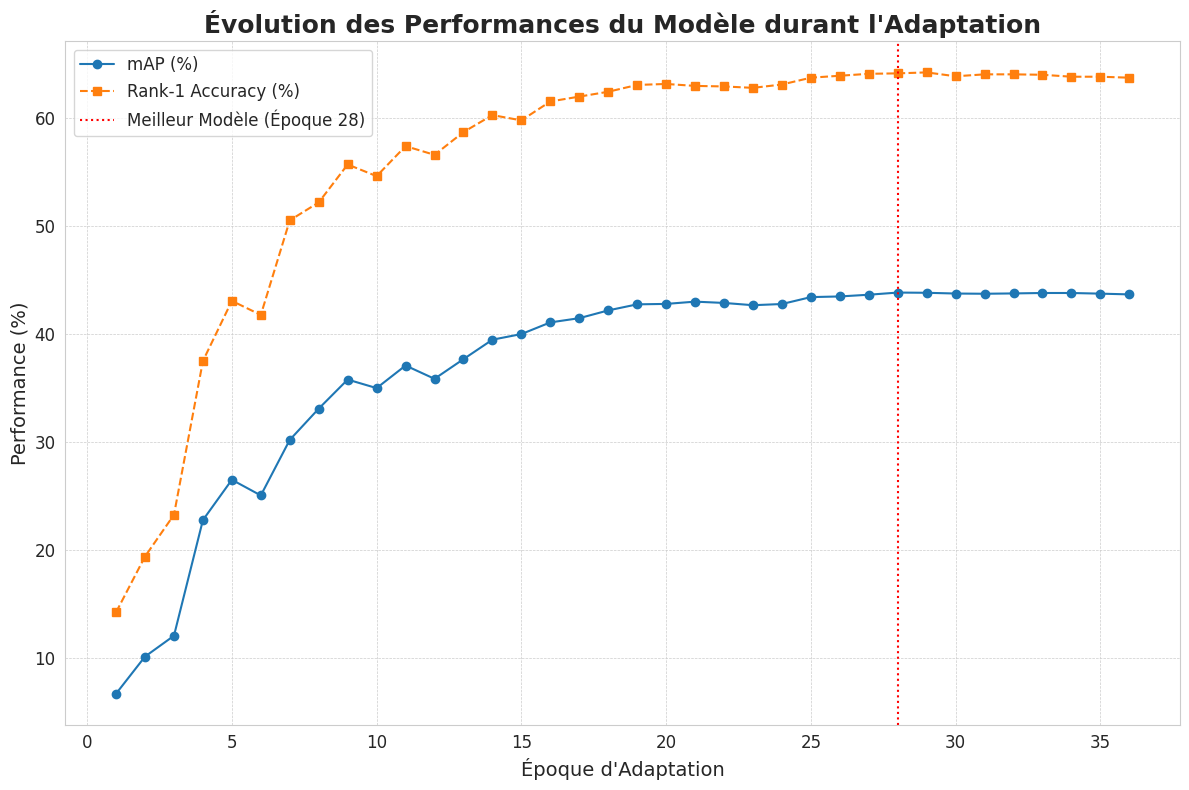

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Données extraites des logs ---
data = {
    'epoch': list(range(1, 37)),
    'mAP': [6.70, 10.13, 12.06, 22.76, 26.49, 25.04, 30.18, 33.07, 35.76, 34.97, 37.06, 35.83, 37.65, 39.45, 39.97, 41.05, 41.44, 42.16, 42.72, 42.76, 42.97, 42.85, 42.64, 42.75, 43.39, 43.45, 43.61, 43.81, 43.79, 43.72, 43.70, 43.73, 43.77, 43.77, 43.71, 43.64],
    'rank1': [14.23, 19.39, 23.25, 37.48, 43.04, 41.74, 50.49, 52.15, 55.66, 54.58, 57.36, 56.55, 58.66, 60.23, 59.74, 61.49, 61.94, 62.39, 63.02, 63.11, 62.93, 62.88, 62.75, 63.06, 63.69, 63.87, 64.05, 64.09, 64.18, 63.82, 64.00, 64.00, 63.96, 63.78, 63.78, 63.69],
}
df = pd.DataFrame(data)
best_epoch = 28

# --- Configuration du style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# --- Génération du graphique ---
plt.figure()
plt.plot(df['epoch'], df['mAP'], marker='o', linestyle='-', label='mAP (%)')
plt.plot(df['epoch'], df['rank1'], marker='s', linestyle='--', label='Rank-1 Accuracy (%)')
plt.axvline(x=best_epoch, color='r', linestyle=':', label=f'Meilleur Modèle (Époque {best_epoch})')
plt.title("Évolution des Performances du Modèle durant l'Adaptation", fontweight='bold')
plt.xlabel("Époque d'Adaptation")
plt.ylabel("Performance (%)")
plt.legend()
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

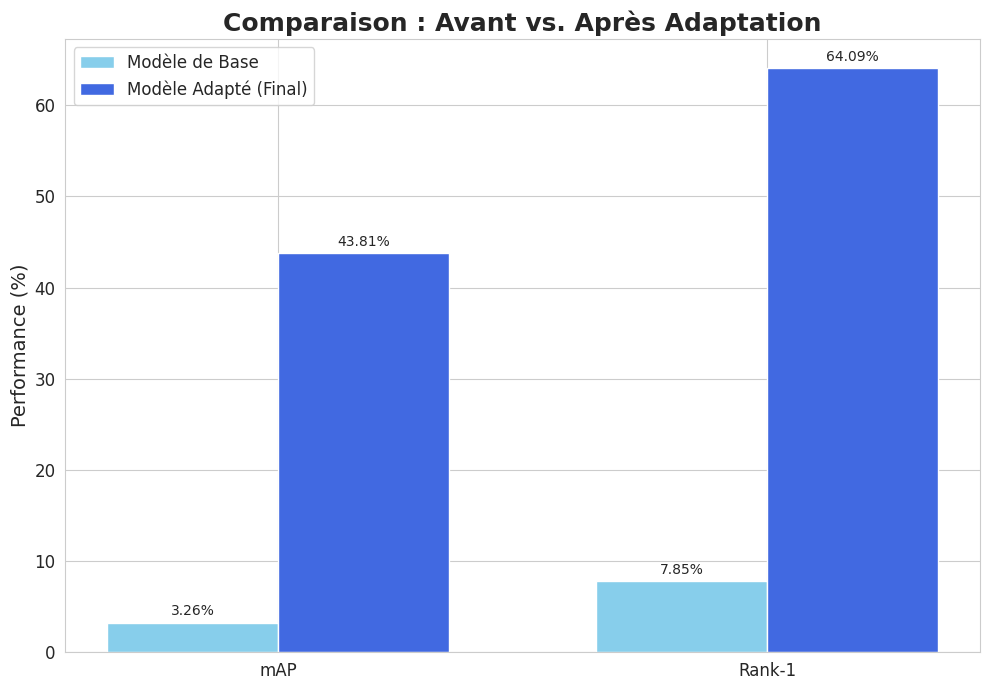

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- Données pour la comparaison ---
baseline_metrics = {'mAP': 3.26, 'Rank-1': 7.85}
final_metrics = {'mAP': 43.81, 'Rank-1': 64.09}

# --- Configuration du style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# --- Génération du graphique ---
labels = ['mAP', 'Rank-1']
x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, baseline_metrics.values(), width, label='Modèle de Base', color='skyblue')
rects2 = ax.bar(x + width/2, final_metrics.values(), width, label='Modèle Adapté (Final)', color='royalblue')

ax.set_ylabel('Performance (%)')
ax.set_title('Comparaison : Avant vs. Après Adaptation', fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Ajouter les valeurs au-dessus des barres
for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}%',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
fig.tight_layout()
plt.show()

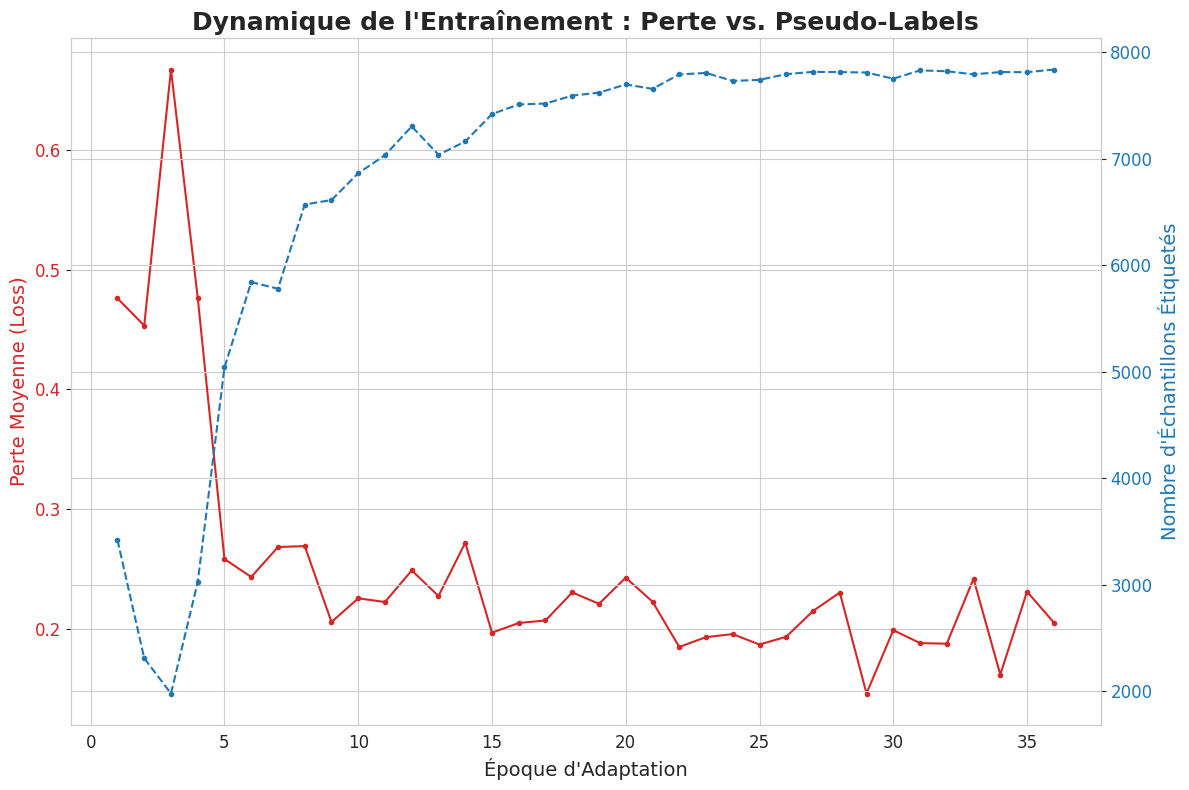

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données extraites des logs ---
data = {
    'epoch': list(range(1, 37)),
    'loss': [0.4760, 0.4532, 0.6670, 0.4765, 0.2583, 0.2433, 0.2683, 0.2691, 0.2057, 0.2255, 0.2224, 0.2488, 0.2274, 0.2719, 0.1968, 0.2049, 0.2070, 0.2304, 0.2209, 0.2427, 0.2227, 0.1849, 0.1931, 0.1956, 0.1869, 0.1934, 0.2149, 0.2303, 0.1460, 0.1989, 0.1881, 0.1876, 0.2418, 0.1618, 0.2311, 0.2053],
    'n_labeled': [3421, 2312, 1980, 3025, 5040, 5841, 5779, 6569, 6611, 6863, 7032, 7302, 7036, 7161, 7418, 7508, 7517, 7591, 7619, 7696, 7655, 7790, 7804, 7729, 7739, 7793, 7814, 7812, 7808, 7750, 7828, 7820, 7791, 7812, 7811, 7836],
}
df = pd.DataFrame(data)

# --- Configuration du style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 12

# --- Génération du graphique ---
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel("Époque d'Adaptation")
ax1.set_ylabel('Perte Moyenne (Loss)', color=color)
ax1.plot(df['epoch'], df['loss'], color=color, marker='.', label='Perte')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel("Nombre d'Échantillons Étiquetés", color=color)
ax2.plot(df['epoch'], df['n_labeled'], color=color, marker='.', linestyle='--', label='Nb. Labels')
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Dynamique de l'Entraînement : Perte vs. Pseudo-Labels", fontweight='bold')
fig.tight_layout()
plt.show()

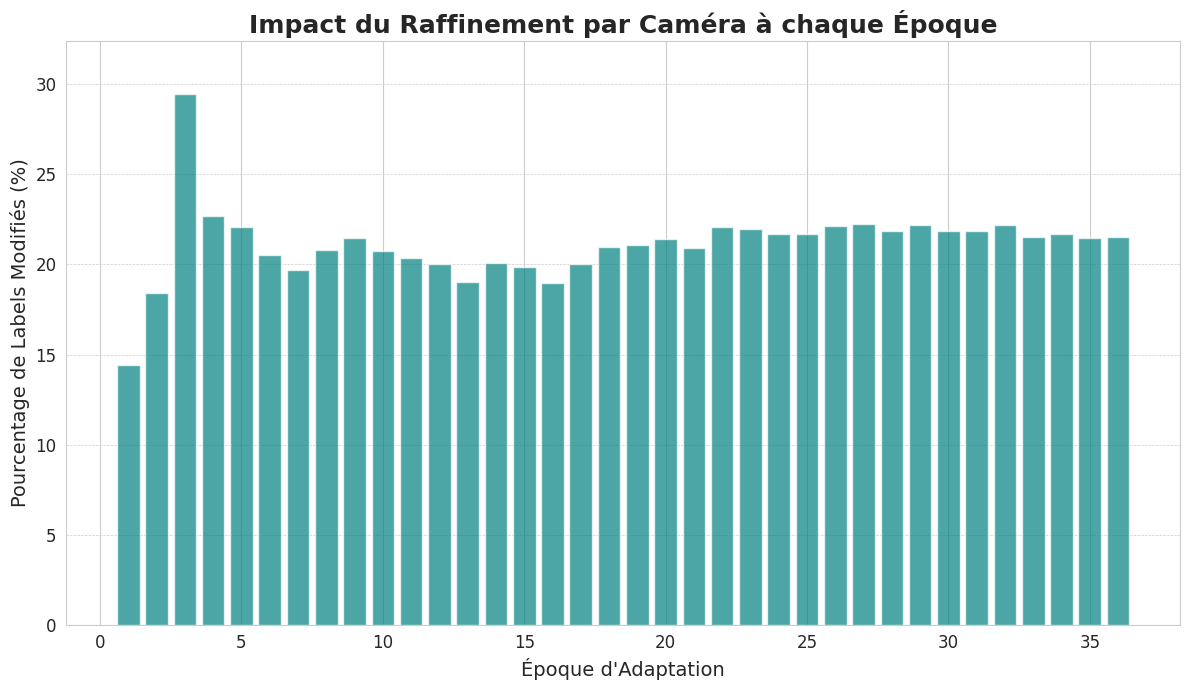

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- Données extraites des logs ---
data = {
    'epoch': list(range(1, 37)),
    'labels_changed_percent': [14.44, 18.43, 29.44, 22.71, 22.10, 20.51, 19.67, 20.81, 21.48, 20.73, 20.35, 20.05, 19.00, 20.08, 19.83, 18.95, 20.05, 20.96, 21.09, 21.43, 20.93, 22.05, 21.95, 21.71, 21.67, 22.16, 22.22, 21.88, 22.18, 21.88, 21.83, 22.21, 21.50, 21.68, 21.48, 21.50]
}
df = pd.DataFrame(data)

# --- Configuration du style ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 18
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# --- Génération du graphique ---
plt.figure()
plt.bar(df['epoch'], df['labels_changed_percent'], color='teal', alpha=0.7)
plt.title("Impact du Raffinement par Caméra à chaque Époque", fontweight='bold')
plt.xlabel("Époque d'Adaptation")
plt.ylabel("Pourcentage de Labels Modifiés (%)")
plt.ylim(0, df['labels_changed_percent'].max() * 1.1) # Marge en haut
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()